# Generative modeling in deep learning

*This notebook consists of common introductory questions, followed by 4 different generative models (GAN, VAE, Flow matching, Diffusion flow), and a common conclusive question. **Choose & implement 2 among the 4 models**, not all of them! If you train more models, write down below the 2 ones you want to be graded on. Do not forget the last common question.*

Generative modeling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modeling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modeling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

<div class="alert alert-info">

- Kullback-Leibler divergence
- Jensen-Shannon divergence
- Hellinger distance
- Maximum Mean Discrepancy

</div>

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

<div class="alert alert-info">

Both density-based and sample-based comparisons present their own problems when it comes to using them as an optimisation objective.

On the one hand, density-based approaches rely on the fact that $p_\theta$ should be known and tractable, which is not always the case (e.g. not the case for GANs). Moreover, as mentioned above, $p_D$ can never be known exactly, in most scenarios we can only sample from it.

On the other hand, sample-based approaches commonly don't allow the computation of gradients as they are non differentiable, a major weakness when it comes to optimization tasks. Furthermore, it is possible that a large number of samples are required to estimate divergence metrics accurately.

</div>

In this work, we will focus on the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GAN), Variational AutoEncoders (VAE), Flow Matching and Diffusion Models, in order to compare them and understand their strengths and weaknesses.

## Dataset

#### Checkerboard (prioritize this dataset)

In [1]:
import torch
import math
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

def generate_batch(num_datapoints: int) -> np.ndarray:
  """Checkerboard dataset."""
  x1 = np.random.rand(num_datapoints) * 4 - 2
  x2 = np.random.rand(num_datapoints) - np.random.randint(0, 2, [num_datapoints]) * 2. + np.floor(x1) % 2
  data = np.stack([x1, x2]).T * 2
  data = (data - data.mean(axis=0)) / data.std(axis=0) # normalize
  return torch.from_numpy(data.astype(np.float32))

train_data = generate_batch(5000)

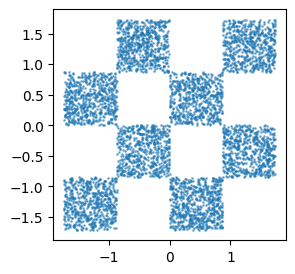

In [2]:
plt.figure(figsize=(3, 3))
plt.scatter(train_data.numpy()[:,0], train_data.numpy()[:,1], s=1.0, alpha=0.5)
plt.show()

It's also good to visualize the density as sometimes generative models overfit particular region of space. Once models are trained, when you sample from them, plot the two densities side-by-side to compare real & synthetic dataset.

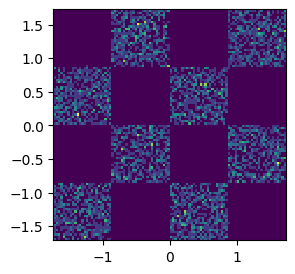

In [3]:
plt.figure(figsize=(3, 3))
plt.hist2d(train_data.numpy()[:,0], train_data.numpy()[:,1], bins=100)
plt.show()

#### Moon (use this one only if your models struggle on checkerboard)

In [5]:
'''
import torch
import math
from sklearn import datasets
import numpy as np

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)
'''

'\nimport torch\nimport math\nfrom sklearn import datasets\nimport numpy as np\n\n# Our dataset is mathematically defined, we can generate batches on the fly and enjoy\n# an infinite-size dataset\ndef generate_batch(batchlen):\n    """This function generates a batch of length \'batchlen\' from the dataset\n    """\n    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)\n    return torch.from_numpy(data)\n'

Let's plot a large batch, to see what the dataset looks like.

In [6]:
'''
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()
'''

'\n%matplotlib inline\nimport matplotlib.pyplot as plt\n\nbatch = generate_batch(5000)\n\nplt.scatter(batch[:,0], batch[:,1], s=2.0)\nplt.show()\n'

It's also good to visualize the density as sometimes generative models overfit particular areas. Once models are trained, when you sample from them, plot the two densities side-by-side to compare real & synthetic dataset.

In [7]:
'''
plt.hist2d(batch.numpy()[:,0], batch.numpy()[:,1], bins=100)
plt.xlim([-1.2,2.2])
plt.ylim([-0.7,1.2])
plt.show()
'''

'\nplt.hist2d(batch.numpy()[:,0], batch.numpy()[:,1], bins=100)\nplt.xlim([-1.2,2.2])\nplt.ylim([-0.7,1.2])\nplt.show()\n'

----
## Generative Adversarial Networks

GANs structure is based on modeling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

<div class="alert alert-info">

The choice of N plays an important role in the context of GANs.

If chosen too low, the generator might struggle to model complex distributions, as the sampled noise may lack diversity. This can potentially lead to issues like mode collapse.

If chosen too high, the generator may have too much capacity, potentially leading to overfitting of the model. Furtheremore, training can become unstable since the latent space tends to become sparser, making it harder to explore and optimise over.

Therefore, it is crucial to choose a balanced noise dimension depending on how much variety we wish our generator to encode.

</div>

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions.
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

<div class="alert alert-info">

Let us consider the case where both distributions are totally different, i.e. where the supports of the two distributions are disjoint. In this scenario, the JSD will become a constant ($log(2)$), hence the gradient with respect to the loss function $\mathcal{L}_D$ will be zero almost everywhere. As a result, the generator won't learn anything, leading to the common phenomenon of mode collapse.

</div>

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

<div class="alert alert-info">

Since the generator loss only uses it's own generated samples as feedback, it struggles to learn what real data looks like, it only knows what appears to be fake.

Hence, if the discriminator is very confident about it's predictions (i.e. $D(G(z)) \approx 0$), this can lead to vanishing gradients. As a result, the generator will struggle to learn anything, training will be unstable and there is the risk of mode collapse.

</div>

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 2)

    def __call__(self, z):
        return self.fc1(z)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)


# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 1)

    def __call__(self, x):
        return self.fc1(x)

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

**Comments regarding the loss implementation:**

For the implementation of GANs, it is common to use the *softplus* function for the loss calculation. It helps to prevent stability issues during training. Let's show how each of the losses considered can be expressed in terms of this function.

Let's consider:

$$softplus(x)\ =\ \frac{1}{\beta}log{(1 + exp(\beta*x)}$$

Now, let's focus on each loss:

1. Discriminator Loss:

 $$ L_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

If we express $D(x)$ using the sigmoid function, we obtain:

$$D(x) = \frac{1}{1 + exp(-f(x))}$$

being $f(x)$ the corresponding logits.

Therefore, we can rewrite the loss as:

$$ L_D = \mathbb{E}_{p_D} \left[ \log {(1 + exp(-f(x))} \right] + \mathbb{E}_{p_\theta} \left[ -\log {(\frac{exp(-f(x))}{1 + exp(-f(x)})}  \right] $$
$$ L_D = \mathbb{E}_{p_D} \left[ \log {(1 + exp(-f(x))} \right] + \mathbb{E}_{p_\theta} \left[ -\log {(\frac{1}{1 + exp(f(x)})}  \right] $$
$$ L_D = \mathbb{E}_{p_D} \left[ \log {(1 + exp(-f(x))} \right] + \mathbb{E}_{p_\theta} \left[ \log {1 + exp(f(x))}  \right] $$

Thus, using softplus we obtain:

$$ L_D = \mathbb{E}_{p_D} \left[ softplus(-f(x)) \right] + \mathbb{E}_{p_\theta} \left[ softplus(f(x)) \right] $$

2. Generator Loss:

$$ L_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $$

Using a similar procedure as for the previous loss, we can rewrite the generator loss as:

$$ L_G = \mathbb{E}_{p_\theta} \left[ -softplus(f(x)) \right] $$

3. Alternative Generator Loss (will be used later)

$$L_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$$

We can rewrite it as:

$$L_G = \mathbb{E}_{p_\theta} [ softplus(-f(x) ]$$



step 0: discriminator: 1.515e+00, generator: -4.872e-01


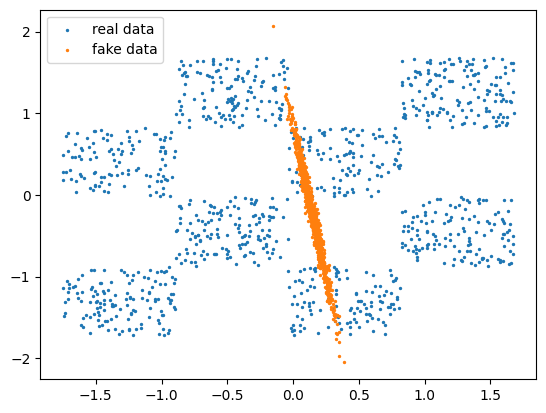

step 1000: discriminator: 1.391e+00, generator: -7.068e-01


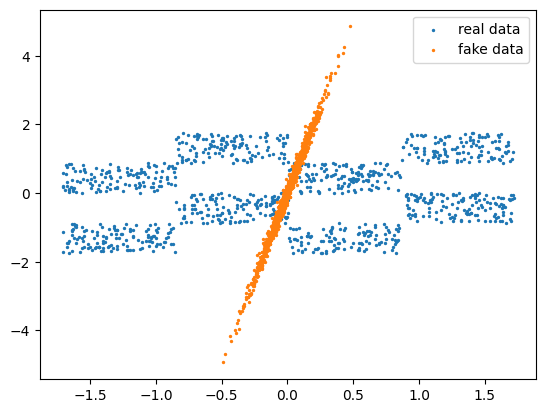

step 2000: discriminator: 1.386e+00, generator: -6.932e-01


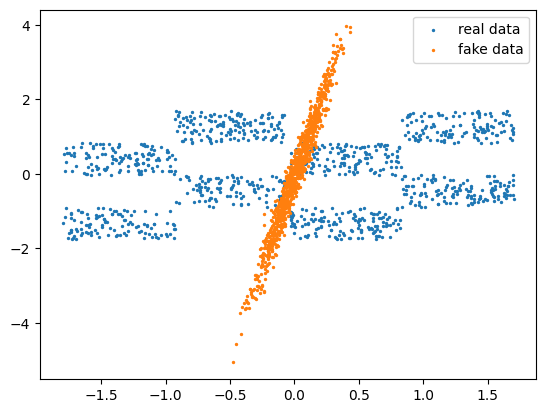

step 3000: discriminator: 1.386e+00, generator: -6.934e-01


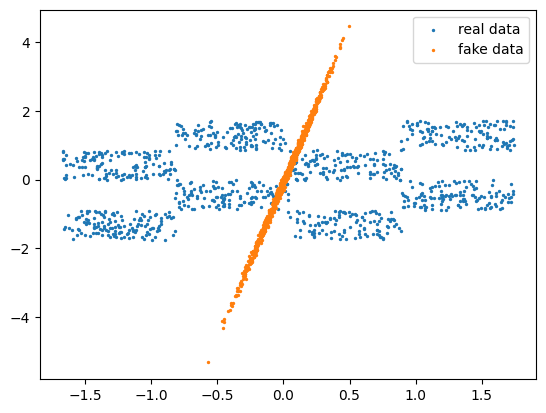

step 4000: discriminator: 1.386e+00, generator: -6.928e-01


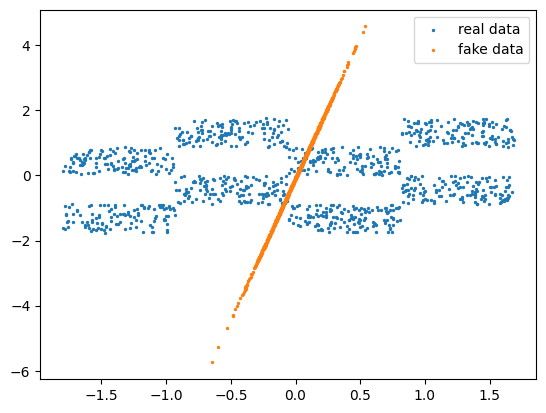

step 5000: discriminator: 1.386e+00, generator: -6.908e-01


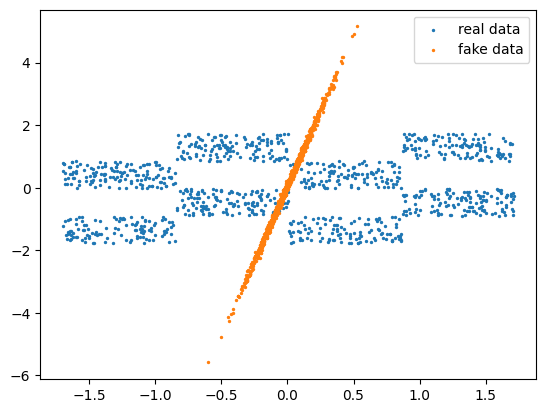

step 6000: discriminator: 1.386e+00, generator: -6.927e-01


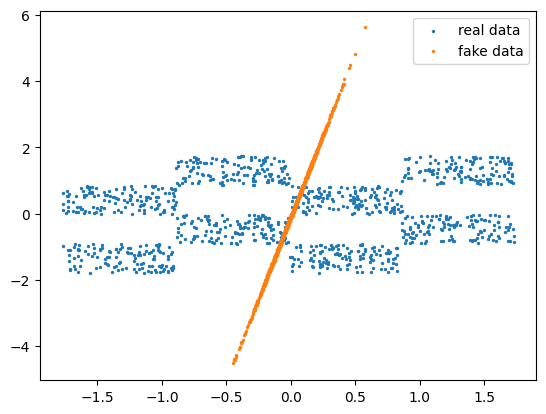

step 7000: discriminator: 1.387e+00, generator: -6.930e-01


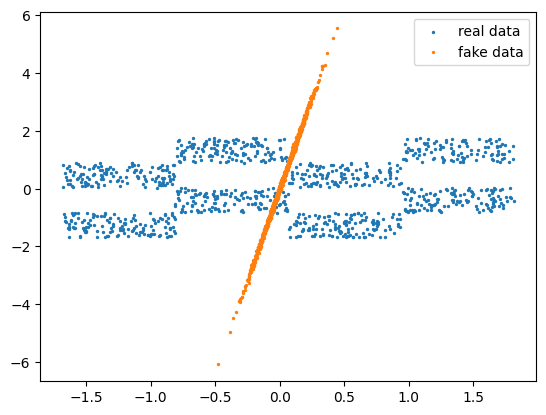

step 8000: discriminator: 1.386e+00, generator: -6.932e-01


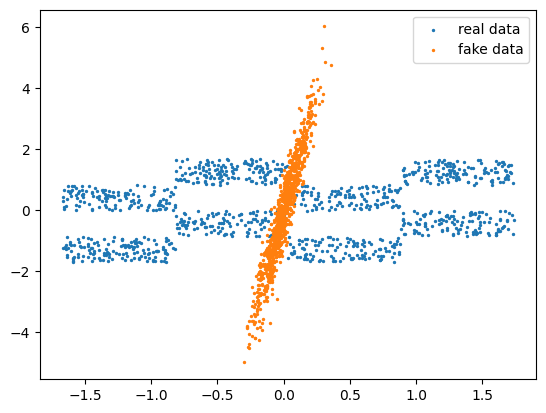

step 9000: discriminator: 1.387e+00, generator: -6.924e-01


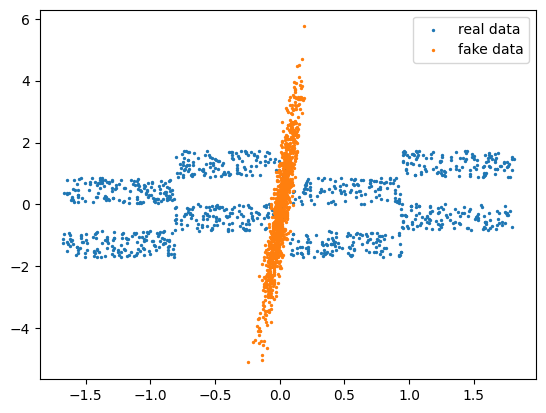

step 10000: discriminator: 1.386e+00, generator: -6.932e-01


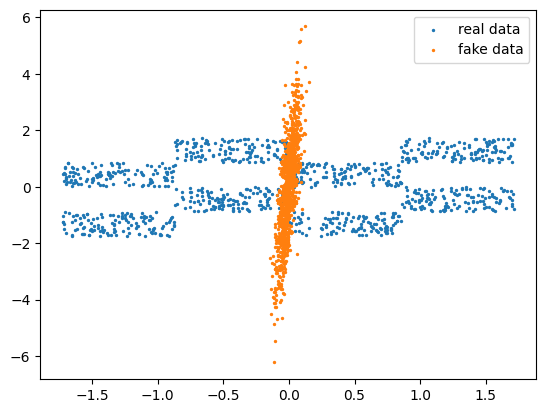

step 11000: discriminator: 1.386e+00, generator: -6.932e-01


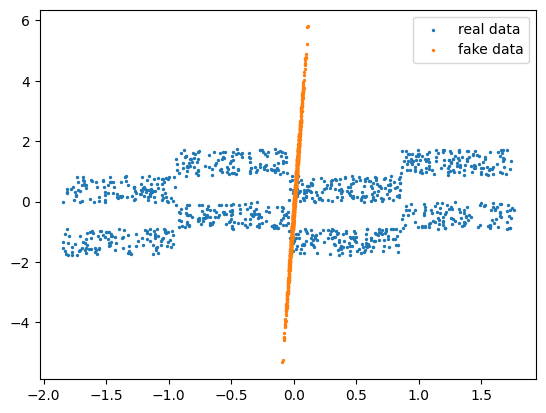

step 12000: discriminator: 1.386e+00, generator: -6.931e-01


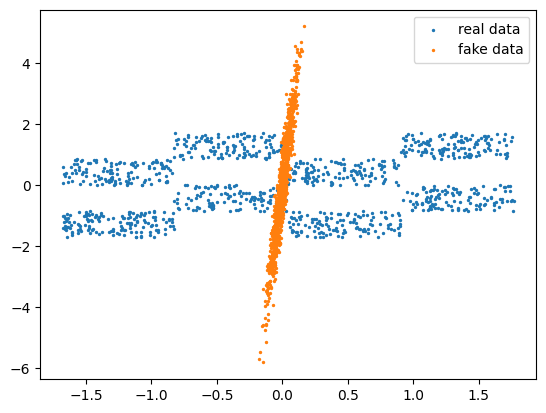

step 13000: discriminator: 1.385e+00, generator: -6.933e-01


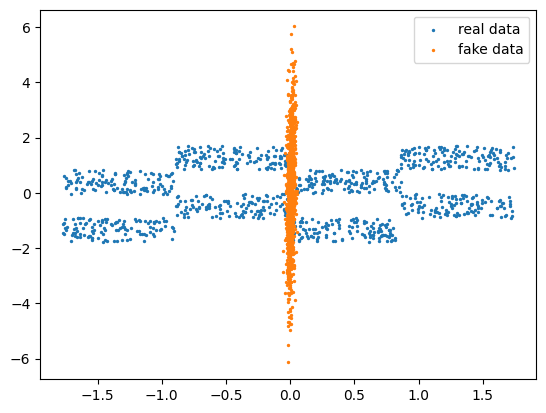

step 14000: discriminator: 1.387e+00, generator: -6.924e-01


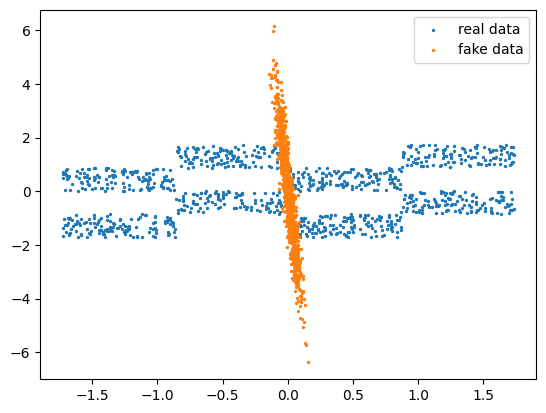

step 15000: discriminator: 1.386e+00, generator: -6.932e-01


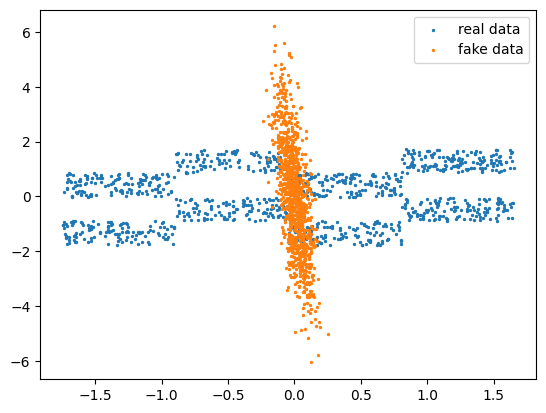

step 16000: discriminator: 1.387e+00, generator: -6.931e-01


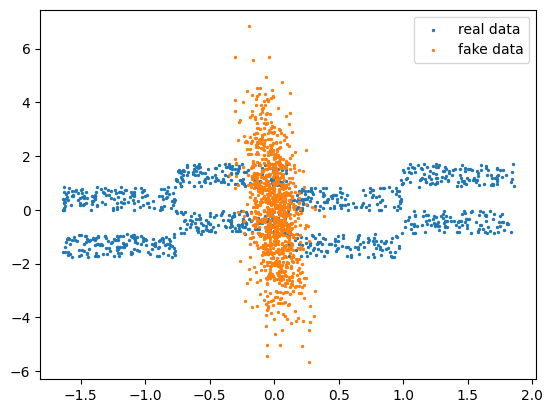

step 17000: discriminator: 1.386e+00, generator: -6.932e-01


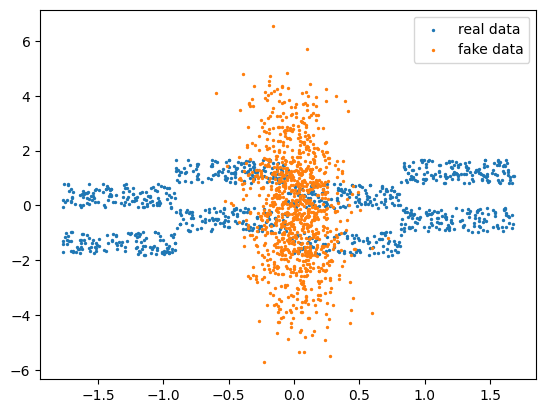

step 18000: discriminator: 1.387e+00, generator: -6.934e-01


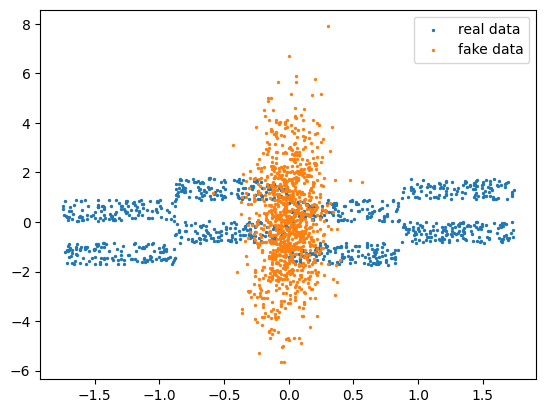

step 19000: discriminator: 1.386e+00, generator: -6.937e-01


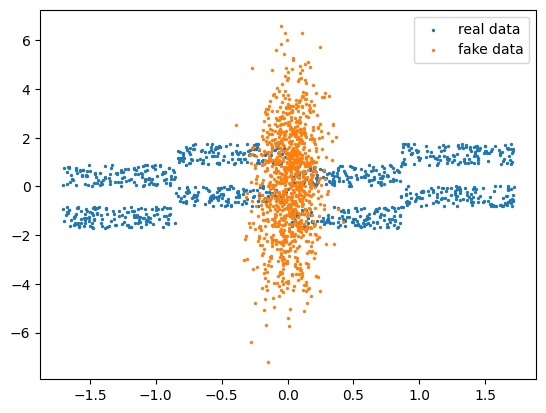

step 20000: discriminator: 1.386e+00, generator: -6.931e-01


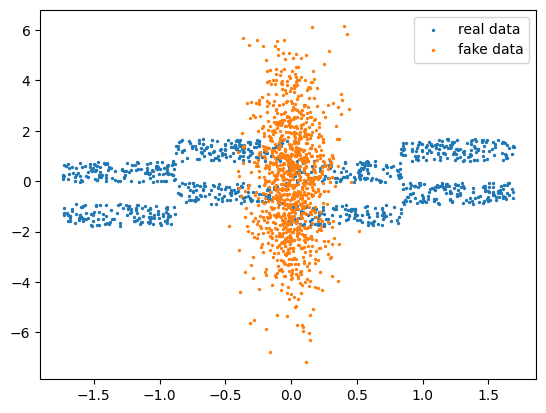

In [5]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)

        real_preds = discriminator(real_batch)
        fake_preds = discriminator(fake_batch.detach())

        # discriminator loss calculation
        real_loss = F.softplus(-real_preds).mean()
        fake_loss = F.softplus(fake_preds).mean()

        disc_loss = real_loss + fake_loss

        disc_loss.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)

    # generator loss calculation
    gen_preds = discriminator(fake_batch)
    gen_loss = -F.softplus(gen_preds).mean()


    gen_loss.backward()
    optim_gen.step()
    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the literature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

<div class="alert alert-info">

As mentioned before, this generator loss only uses it's own generated samples as feedback, it struggles to learn what real data looks like, it only knows what appears to be fake.

Hence, if the discriminator is very confident about it's predictions (i.e. $D(G(z)) \approx 0$), this can lead to vanishing gradients. As a result, the generator will struggle to learn anything, training will be unstable and there is the risk of mode collapse at the beginning of training, from which the generator can't recover.

We could have anticipated this because, as mentioned in Q4, we have quite disjoint initial supports, leading to vanishing gradients and the generator not learning anything.

</div>

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

step 0: discriminator: 1.334e+00, generator: 9.961e-01


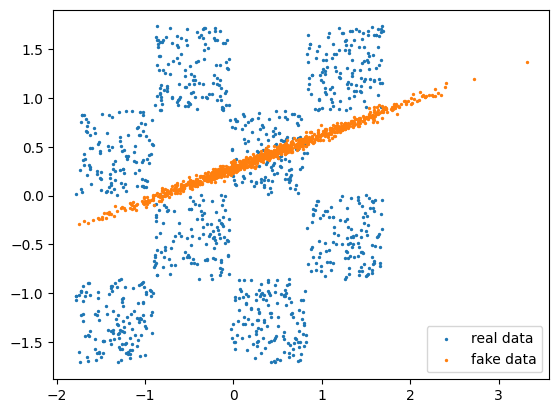

step 1000: discriminator: 1.386e+00, generator: 6.932e-01


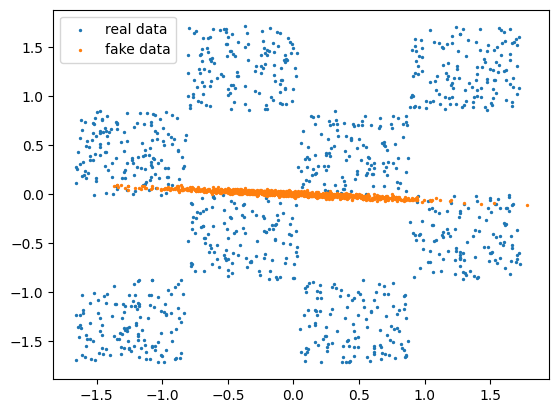

step 2000: discriminator: 1.386e+00, generator: 6.927e-01


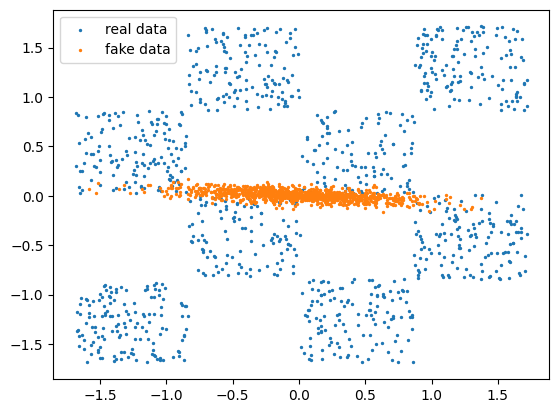

step 3000: discriminator: 1.386e+00, generator: 6.932e-01


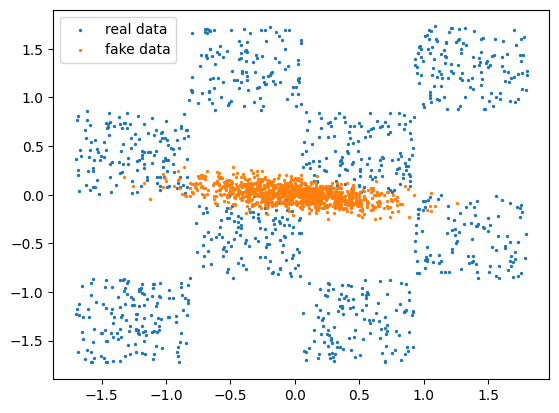

step 4000: discriminator: 1.386e+00, generator: 6.932e-01


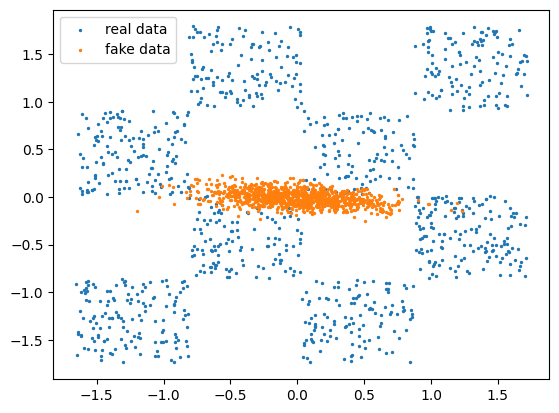

step 5000: discriminator: 1.386e+00, generator: 6.930e-01


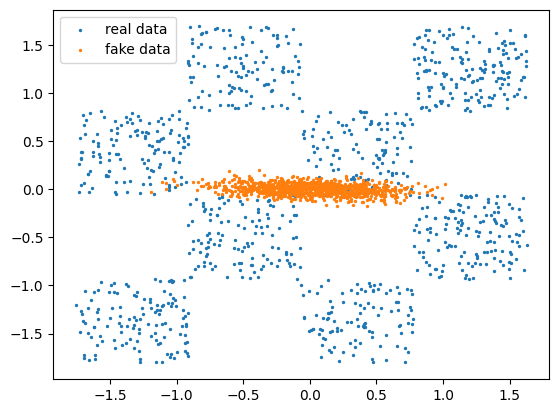

step 6000: discriminator: 1.386e+00, generator: 6.931e-01


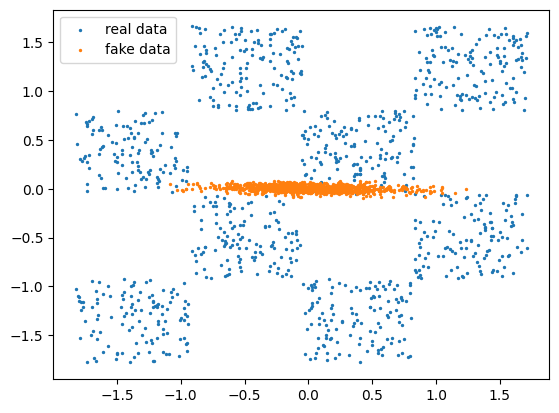

step 7000: discriminator: 1.386e+00, generator: 6.931e-01


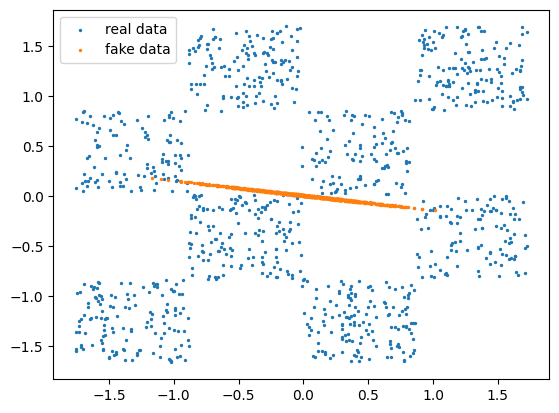

step 8000: discriminator: 1.386e+00, generator: 6.932e-01


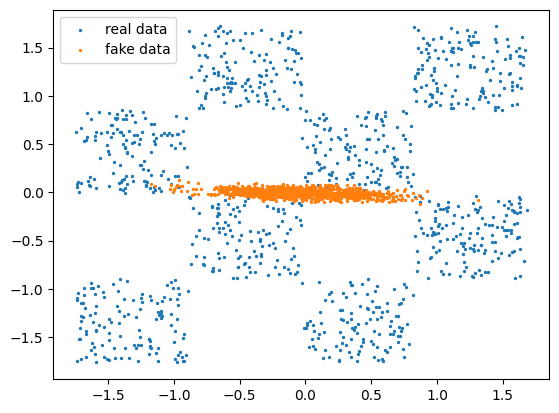

step 9000: discriminator: 1.386e+00, generator: 6.932e-01


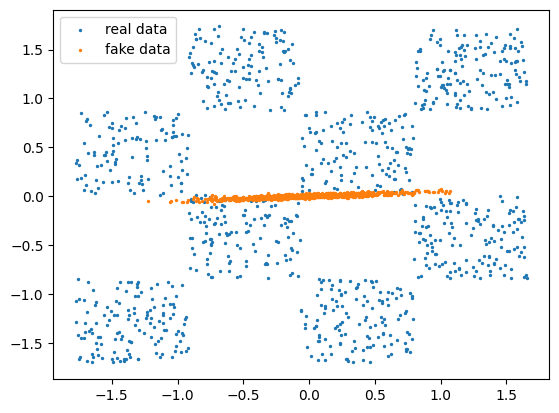

step 10000: discriminator: 1.386e+00, generator: 6.930e-01


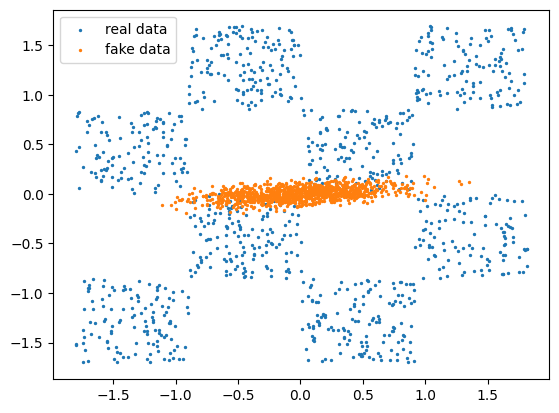

step 11000: discriminator: 1.386e+00, generator: 6.932e-01


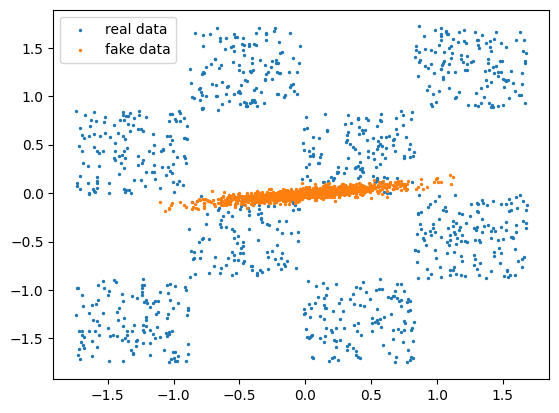

step 12000: discriminator: 1.386e+00, generator: 6.931e-01


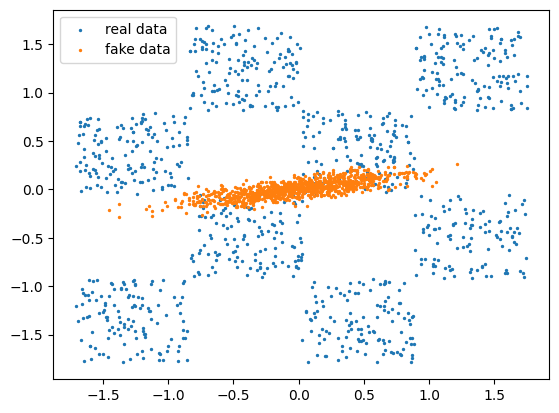

step 13000: discriminator: 1.386e+00, generator: 6.930e-01


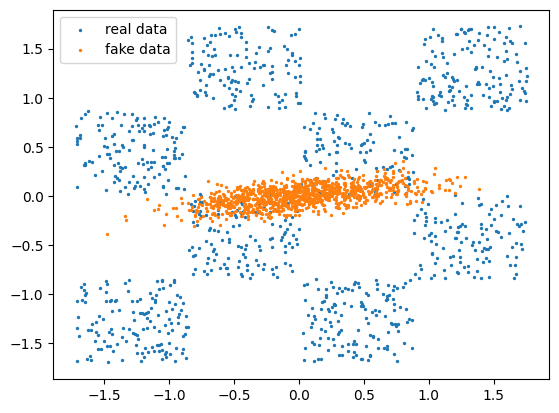

step 14000: discriminator: 1.386e+00, generator: 6.933e-01


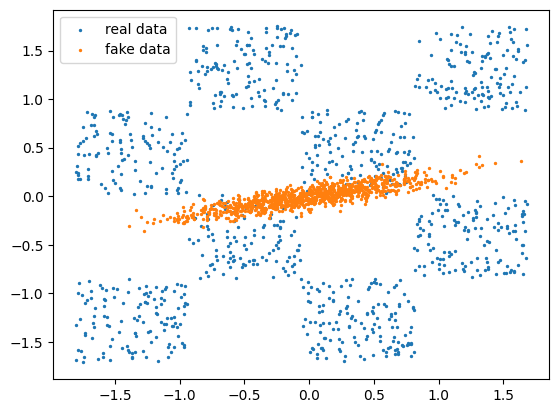

step 15000: discriminator: 1.386e+00, generator: 6.931e-01


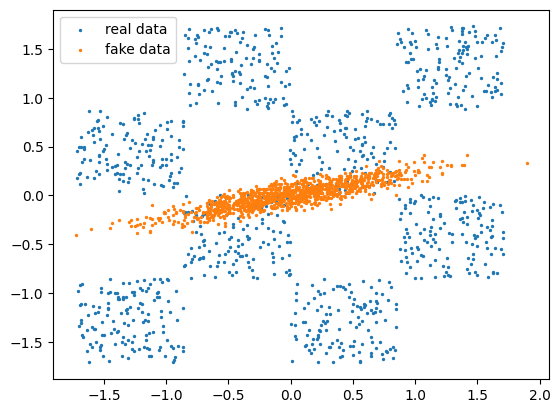

step 16000: discriminator: 1.386e+00, generator: 6.932e-01


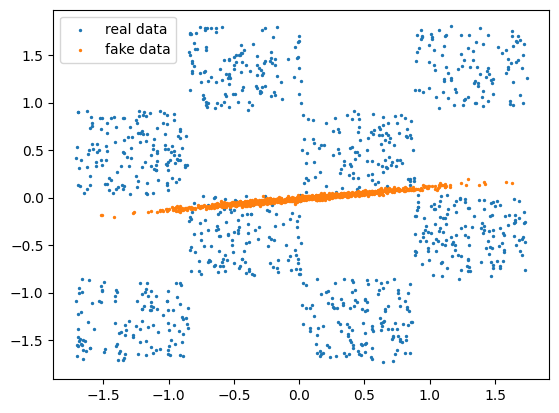

step 17000: discriminator: 1.386e+00, generator: 6.932e-01


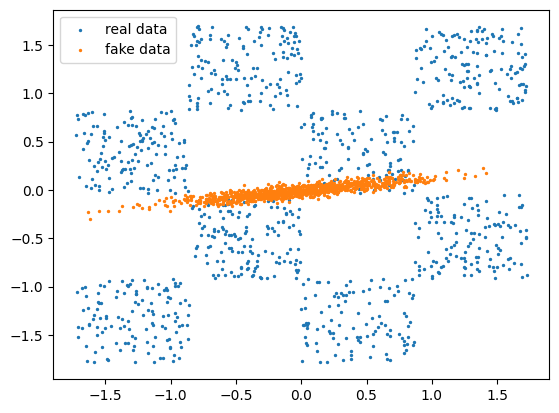

step 18000: discriminator: 1.386e+00, generator: 6.931e-01


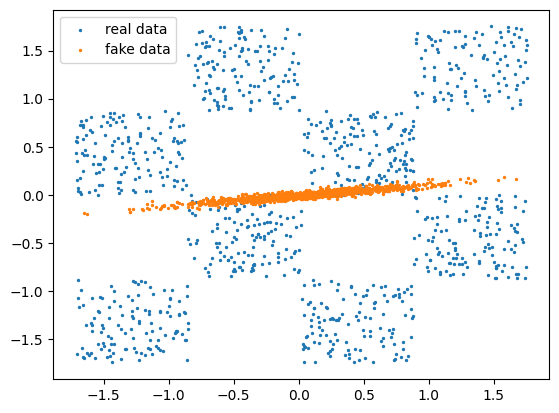

step 19000: discriminator: 1.386e+00, generator: 6.932e-01


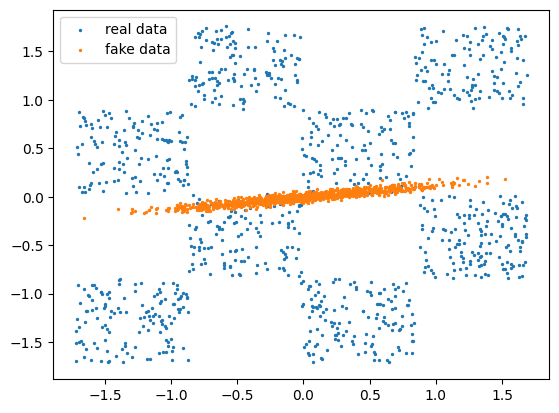

step 20000: discriminator: 1.386e+00, generator: 6.934e-01


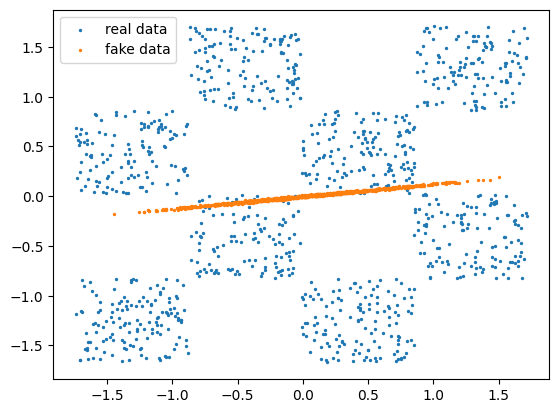

In [11]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)

        real_preds = discriminator(real_batch)
        fake_preds = discriminator(fake_batch.detach())

        # real_loss = F.binary_cross_entropy_with_logits(real_preds, torch.ones_like(real_preds))
        # fake_loss = F.binary_cross_entropy_with_logits(fake_preds, torch.zeros_like(fake_preds))

        real_loss = F.softplus(-real_preds).mean()
        fake_loss = F.softplus(fake_preds).mean()

        disc_loss = real_loss + fake_loss

        disc_loss.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)

    gen_preds = discriminator(fake_batch)
    # gen_preds_sigmoid = torch.sigmoid(gen_preds)
    # gen_loss = -torch.mean(torch.log(gen_preds_sigmoid))

    gen_loss = F.softplus(-gen_preds).mean()

    gen_loss.backward()
    optim_gen.step()
    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

<div class="alert alert-info">

While the fake data is still quite different from the real data, we can see that the gradients are not vanishing and that the generator still has the ability to learn.

</div>

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

In [12]:
import torch.nn as nn
import torch.nn.functional as F

PRIOR_N = 2

class Generator(nn.Module):
    def __init__(self, depth=1, width=32):
        super().__init__()
        layers = []

        layers.append(nn.Linear(PRIOR_N, width))
        layers.append(nn.ReLU())

        for _ in range(depth-1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(width, 2))

        self.model = nn.Sequential(*layers)

    def forward(self, z):
        return self.model(z)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self(z)

class Discriminator(nn.Module):
    def __init__(self, depth=1, width=32):
        super().__init__()
        layers = []

        layers.append(nn.Linear(2, width))
        layers.append(nn.LeakyReLU(0.2))

        for _ in range(depth-1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.LeakyReLU(0.2))

        layers.append(nn.Linear(width, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [13]:
def train_gan(gen_depth=1, gen_width=32, disc_depth=1, disc_width=32, train_ratio=1, n_iter=20001):
    generator = Generator(depth=gen_depth, width=gen_width)
    discriminator = Discriminator(depth=disc_depth, width=disc_width)

    optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.9))
    optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.9))

    print(f'Gen. depth={gen_depth}, Gen. width={gen_width}, Disc. depth={disc_depth}, Disc. width={disc_width}, Train Ratio={train_ratio}')

    for i in range(n_iter):
        for _ in range(train_ratio):
            discriminator.zero_grad()
            real_batch = generate_batch(BATCHLEN)
            fake_batch = generator.generate(BATCHLEN)

            real_preds = discriminator(real_batch)
            fake_preds = discriminator(fake_batch.detach())

            # real_loss = F.binary_cross_entropy_with_logits(real_preds, torch.ones_like(real_preds))
            # fake_loss = F.binary_cross_entropy_with_logits(fake_preds, torch.zeros_like(fake_preds))
            real_loss = F.softplus(-real_preds).mean()
            fake_loss = F.softplus(fake_preds).mean()

            disc_loss = real_loss + fake_loss
            disc_loss.backward()
            optim_disc.step()

        generator.zero_grad()
        fake_batch = generator.generate(BATCHLEN)
        gen_preds = discriminator(fake_batch)

        # gen_preds_sigmoid = torch.sigmoid(gen_preds)
        # gen_loss = -torch.mean(torch.log(gen_preds_sigmoid))
        gen_loss = F.softplus(-gen_preds).mean()

        gen_loss.backward()
        optim_gen.step()

    return generator, discriminator

Gen. depth=1, Gen. width=16, Disc. depth=2, Disc. width=32, Train Ratio=1
Gen. depth=1, Gen. width=32, Disc. depth=2, Disc. width=32, Train Ratio=1
Gen. depth=1, Gen. width=64, Disc. depth=2, Disc. width=32, Train Ratio=1
Gen. depth=2, Gen. width=16, Disc. depth=2, Disc. width=32, Train Ratio=1
Gen. depth=2, Gen. width=32, Disc. depth=2, Disc. width=32, Train Ratio=1
Gen. depth=2, Gen. width=64, Disc. depth=2, Disc. width=32, Train Ratio=1
Gen. depth=3, Gen. width=16, Disc. depth=2, Disc. width=32, Train Ratio=1
Gen. depth=3, Gen. width=32, Disc. depth=2, Disc. width=32, Train Ratio=1
Gen. depth=3, Gen. width=64, Disc. depth=2, Disc. width=32, Train Ratio=1
Gen. depth=2, Gen. width=32, Disc. depth=1, Disc. width=16, Train Ratio=1
Gen. depth=2, Gen. width=32, Disc. depth=1, Disc. width=32, Train Ratio=1
Gen. depth=2, Gen. width=32, Disc. depth=1, Disc. width=64, Train Ratio=1
Gen. depth=2, Gen. width=32, Disc. depth=2, Disc. width=16, Train Ratio=1
Gen. depth=2, Gen. width=32, Disc. dep

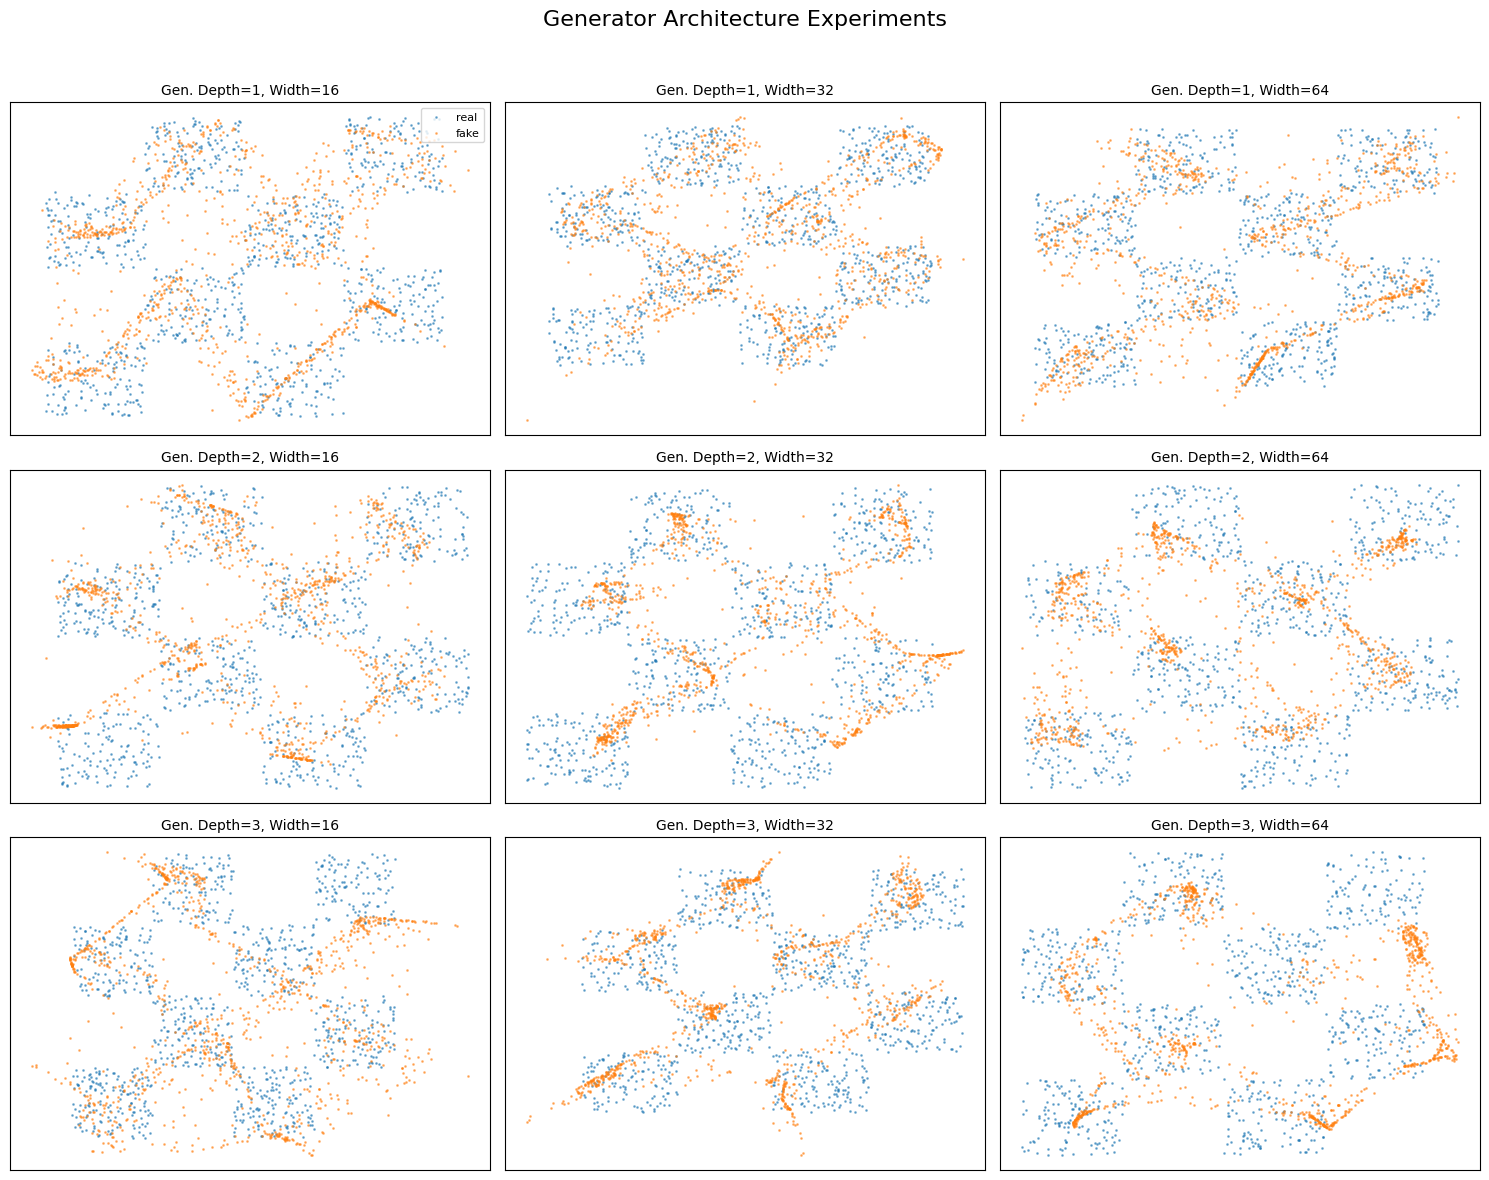

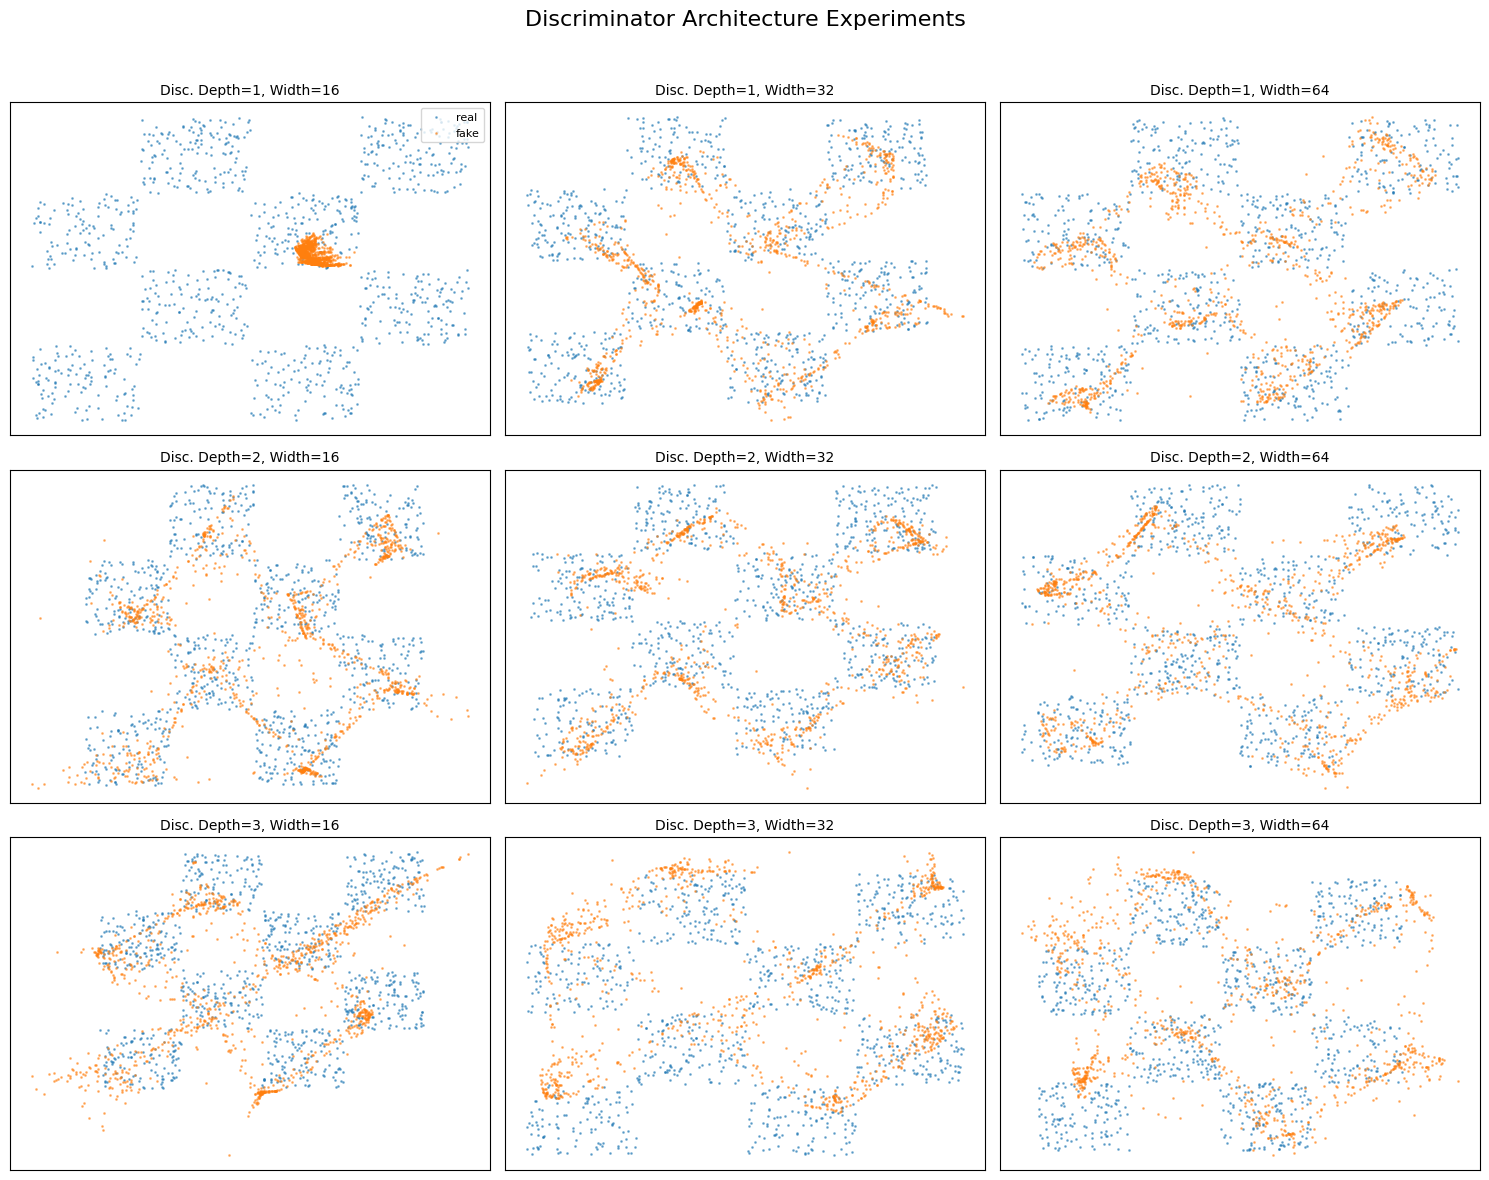

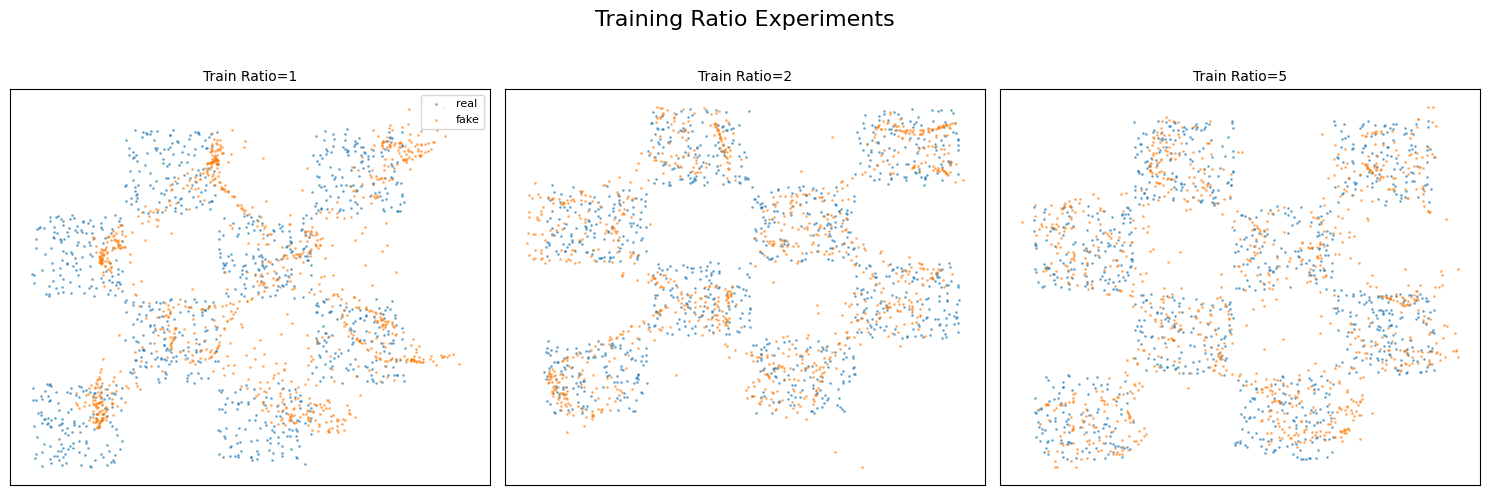

In [14]:
experiments = []
for gen_depth in [1, 2, 3]:
    for gen_width in [16, 32, 64]:
        generator, discriminator = train_gan(
            gen_depth=gen_depth,
            gen_width=gen_width,
            disc_depth=2,
            disc_width=32,
            train_ratio=1,
            n_iter=20001
        )
        experiments.append({
            'name': f'Gen. D{gen_depth}_W{gen_width}',
            'generator': generator,
            'discriminator': discriminator
        })

for disc_depth in [1, 2, 3]:
    for disc_width in [16, 32, 64]:
        generator, discriminator = train_gan(
            gen_depth=2,
            gen_width=32,
            disc_depth=disc_depth,
            disc_width=disc_width,
            train_ratio=1,
            n_iter=20001
        )
        experiments.append({
            'name': f'Disc. D{disc_depth}_W{disc_width}',
            'generator': generator,
            'discriminator': discriminator
        })

for train_ratio in [1, 2, 5]:
    generator, discriminator = train_gan(
        gen_depth=2,
        gen_width=32,
        disc_depth=2,
        disc_width=32,
        train_ratio=train_ratio,
        n_iter=20001
    )
    experiments.append({
        'name': f'Train Ratio {train_ratio}',
        'generator': generator,
        'discriminator': discriminator
    })

# Generator architecture plot
plt.figure(figsize=(15, 12))
plt.suptitle("Generator Architecture Experiments", fontsize=16)

for i, depth in enumerate([1, 2, 3]):
    for j, width in enumerate([16, 32, 64]):
        plt.subplot(3, 3, i*3 + j + 1)

        exp_name = f'Gen. D{depth}_W{width}'
        exp = next((e for e in experiments if e['name'] == exp_name), None)

        if exp and 'generator' in exp:
            generator = exp['generator']
            real_batch = generate_batch(1024)
            fake_batch = generator.generate(1024).detach()

            plt.scatter(real_batch[:,0], real_batch[:,1], s=1.0, alpha=0.5, label='real')
            plt.scatter(fake_batch[:,0], fake_batch[:,1], s=1.0, alpha=0.5, label='fake')

            if i == 0 and j == 0:  # Only add legend to first plot
                plt.legend(loc='upper right', fontsize=8)

        plt.title(f'Gen. Depth={depth}, Width={width}', fontsize=10)
        plt.xticks([])
        plt.yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('generator_experiments.png', dpi=300)
plt.show()

# Discriminator architecture plot
plt.figure(figsize=(15, 12))
plt.suptitle("Discriminator Architecture Experiments", fontsize=16)

for i, depth in enumerate([1, 2, 3]):
    for j, width in enumerate([16, 32, 64]):
        plt.subplot(3, 3, i*3 + j + 1)

        exp_name = f'Disc. D{depth}_W{width}'
        exp = next((e for e in experiments if e['name'] == exp_name), None)

        if exp and 'generator' in exp:
            generator = exp['generator']
            real_batch = generate_batch(1024)
            fake_batch = generator.generate(1024).detach()

            plt.scatter(real_batch[:,0], real_batch[:,1], s=1.0, alpha=0.5, label='real')
            plt.scatter(fake_batch[:,0], fake_batch[:,1], s=1.0, alpha=0.5, label='fake')

            if i == 0 and j == 0:
                plt.legend(loc='upper right', fontsize=8)

        plt.title(f'Disc. Depth={depth}, Width={width}', fontsize=10)
        plt.xticks([])
        plt.yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('discriminator_experiments.png', dpi=300)
plt.show()

# Training Ratio plot
plt.figure(figsize=(15, 5))
plt.suptitle("Training Ratio Experiments", fontsize=16)

for i, ratio in enumerate([1, 2, 5]):
    plt.subplot(1, 3, i + 1)

    exp_name = f'Train Ratio {ratio}'
    exp = next((e for e in experiments if e['name'] == exp_name), None)

    if exp and 'generator' in exp:
        generator = exp['generator']
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()

        plt.scatter(real_batch[:,0], real_batch[:,1], s=1.0, alpha=0.5, label='real')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=1.0, alpha=0.5, label='fake')

        if i == 0:
            plt.legend(loc='upper right', fontsize=8)

    plt.title(f'Train Ratio={ratio}', fontsize=10)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('train_ratio_experiments.png', dpi=300)
plt.show()

<div class="alert alert-info">

**Results Analysis:**

- *Generator capacity*: We can notice that, for a fixed complexity (depth and width), we can obtain descent results even with the simplest model: depth = 1, width = 16. Increasing too much the complexity do not necessarily lead to better results as we obtained the best results for depth = 2 and width = 32.
- *Discriminator capacity*: Unlike the generator case, for the discriminator we were not able to obtain good results with the simplest model. For this case there is a clear collapsing. Therefore, we can say that it is crutial to have an expressive enough discriminator to obtain good performances with GANs. Moreover, as for the generator, increasing too much the complexity does not improve the generation quality.
- *Train ratio*: To understand the impact of this parameter, we fixed the discriminator and generator capacities considering the results obtained before in depth = 2 and width = 32. We can notice that, even when the results are not too bad for all the values considered, the better ones are for $\text{Train Ratio} \in \{2,5\}$ and slightly better for $\text{Train Ratio} = 5$. It suggests that a good compromise between generator and discriminator training is required to improve generation performance in GANs.

</div>

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)
- A Style-Based Generator Architecture for Generative Adversarial Networks *(Karras et al.)* [arxiv:1812.04948v3](https://arxiv.org/abs/1812.04948v3)

----
## Variational AutoEncoders

Another well-known approach to generative modeling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

<div class="alert alert-info">

**Answer:**

Applying the linearity of the expectation, we have

$$
D_{KL}(p_D\|p_\theta) = \mathbb{E}\left[\log(\frac{p_D}{p_\theta})\right] = \mathbb{E}_{p_D}[\log(p_D)]-\mathbb{E}_{p_D}[\log(p_\theta)].
$$
As $\mathbb{E}_{p_D}[\log(p_D)]$ does not depend on $\theta$, maximizing $\mathbb{E}_{p_D}[\log(p_\theta)]$ is equivalent to minimizing $D_{KL}(p_D\|p_\theta)$.

</div>

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

![VAE](./vae-gaussian.png)

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

<div class="alert alert-info">

**Answer:**

The main issue is that during training, we sample from the encoded distribution $q_\phi(z | x)$ , whereas during inference, we sample from the prior $p(z)$. As a result, the decoder is trained only on the regions of the latent space covered by the training data, not the full latent space. If a sample drawn at inference time falls in a region that was unseen during training, the generated output may be poor. This issue becomes more significant when the learned latent space does not closely match the fixed prior.

</div>

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**




<div class="alert alert-info">

**Answer:**

We want to compute:

$D_{\mathrm{KL}}(q_\phi(z | x) \| p(z)) = \mathbb{E}_{z \sim q_{\phi}}[\log \frac{q_\phi(z|x)}{p(z)}]$

Let:
- $q_\phi(z|x) = N(\mu_\phi(x), Diag(\sigma_\phi^2(x)))$
- $p(z) = N(0, Id)$

For simplicity let's consider:

- $\Sigma = Diag(\sigma_\phi^2(x))$
- $\mu = \mu_\phi(x)$

Using the KL divergence formula between two Gaussians:

$$D_{KL}(N(\mu, \Sigma) \| N(0, Id)) = \frac{1}{2} \left( \mathrm{Tr}(\Sigma) + \mu^T \mu - d - \log \det \Sigma \right)$$

Since $\Sigma = \mathrm{Diag}(\sigma_1^2, \dots, \sigma_d^2)$, we have:

- $ \mathrm{Tr}(\Sigma) = \sum_{i=1}^d \sigma_i^2 $
- $ \mu^T \mu = \sum_{i=1}^d \mu_i^2 $
- $ \log \det \Sigma = \sum_{i=1}^d \log \sigma_i^2 $

Substitute into the formula:

$D_{\mathrm{KL}}(q_\phi(z \mid x) \| p(z)) = \frac{1}{2} \sum_{i=1}^d \left( \sigma_i^2 + \mu_i^2 - 1 - \log \sigma_i^2 \right)$

This gives us the final result:

$\boxed{D_{KL}(q_\phi(z \mid x) \| p(z)) = \frac{1}{2} \sum_{i=1}^{d} \left( \sigma_{\phi,i}^2(x) + \mu_{\phi,i}^2(x) - 1 - \log \sigma_{\phi,i}^2(x) \right)}$

</div>

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

<div class="alert alert-info">

**Answer:**

Given:
$$p_\theta(x | z) \sim N(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$$

The **log-likelihood** of a multivariate diagonal Gaussian is:

$$\log p_\theta(x \mid z) = -\frac{d}{2} \log (2\pi) - \frac{1}{2} \sum_{i=1}^{d} \left[ \log \sigma_{\theta,i}^2(z) + \frac{(x_i - \mu_{\theta,i}(z))^2}{\sigma_{\theta,i}^2(z)} \right]$$

So, the **negative log-likelihood** will be:

$$-\log p_\theta(x \mid z) = \frac{d}{2} \log (2\pi) + \frac{1}{2} \sum_{i=1}^{d} \left[ \log \sigma_{\theta,i}^2(z) + \frac{(x_i - \mu_{\theta,i}(z))^2}{\sigma_{\theta,i}^2(z)} \right]$$

This is the reconstruction loss used in the ELBO.

</div>

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [8]:
# Choose a value for the latent dimension
LATENT_N = 10

# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(2, LATENT_N)
        self.fc_logvar = nn.Linear(2, LATENT_N)

    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)


# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(LATENT_N, 2)
        self.fc_logvar = nn.Linear(LATENT_N, 2)

    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$.

step 0: KL: 4.003e+02, rec: 6.004e+02


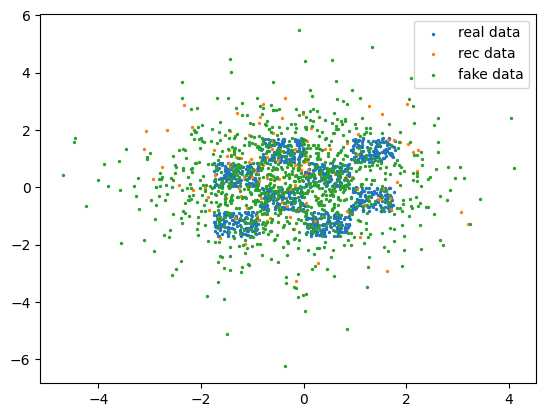

step 1000: KL: 3.983e-01, rec: 5.616e+02


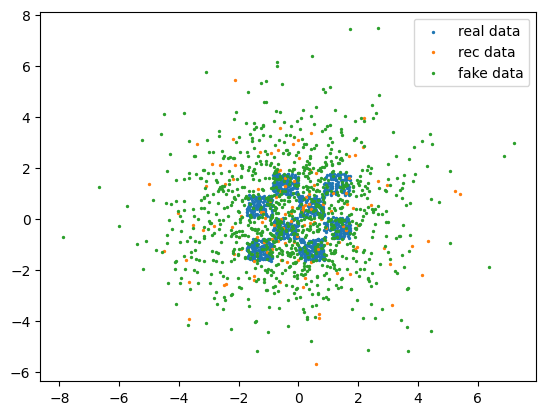

step 2000: KL: 6.172e-02, rec: 6.384e+02


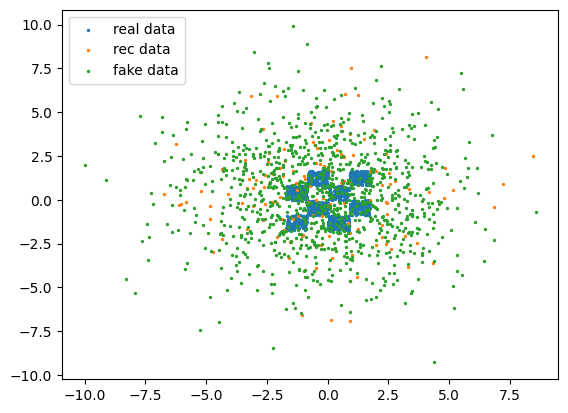

step 3000: KL: 1.652e-02, rec: 7.224e+02


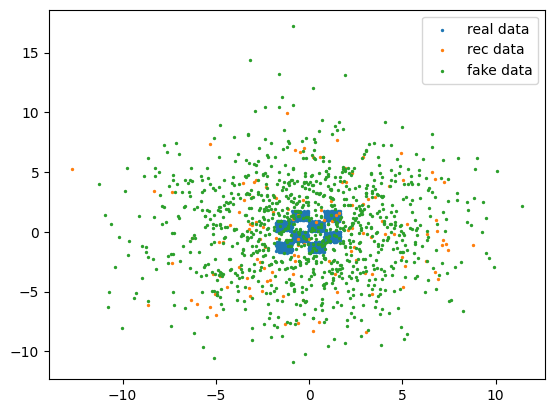

step 4000: KL: 1.010e-02, rec: 7.755e+02


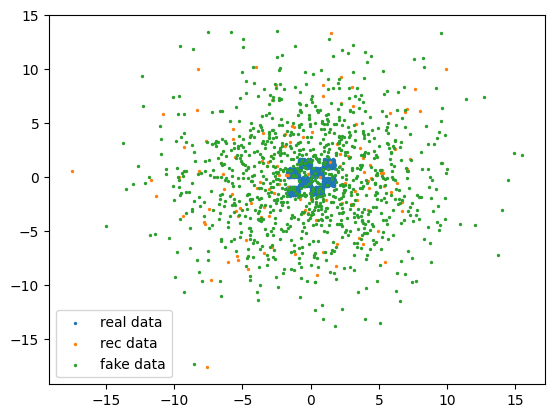

step 5000: KL: 7.850e-03, rec: 8.116e+02


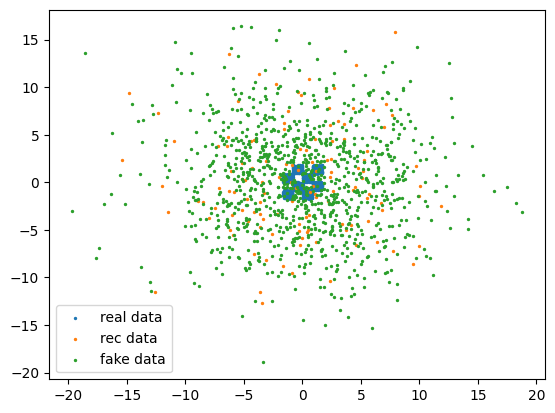

step 6000: KL: 5.942e-03, rec: 8.556e+02


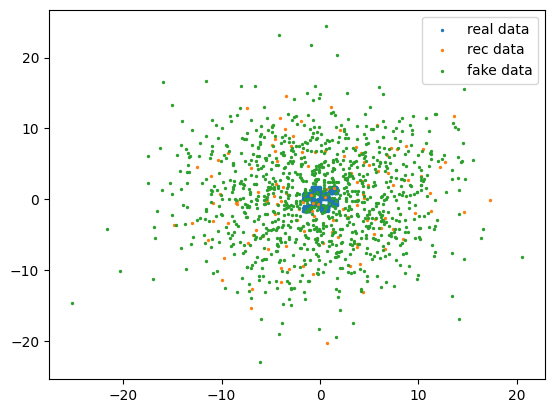

step 7000: KL: 4.486e-03, rec: 8.583e+02


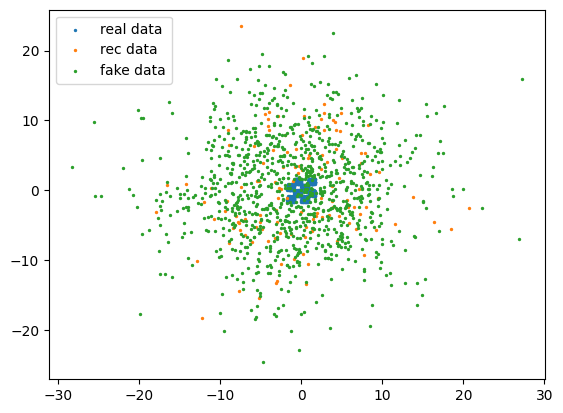

step 8000: KL: 5.580e-03, rec: 8.761e+02


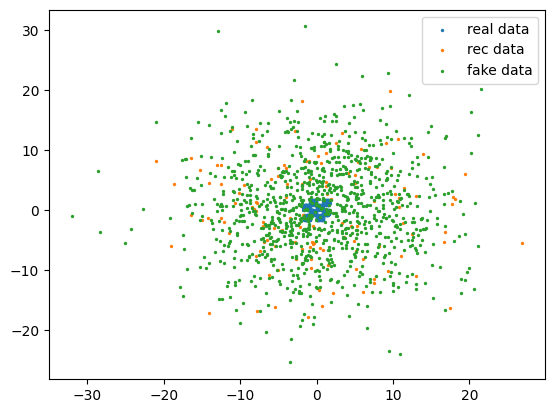

step 9000: KL: 8.355e-03, rec: 9.195e+02


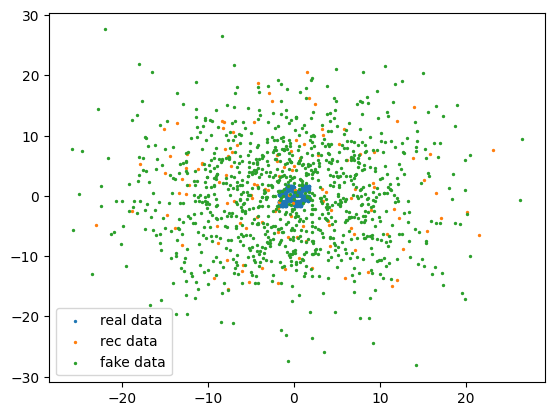

step 10000: KL: 8.796e-03, rec: 9.140e+02


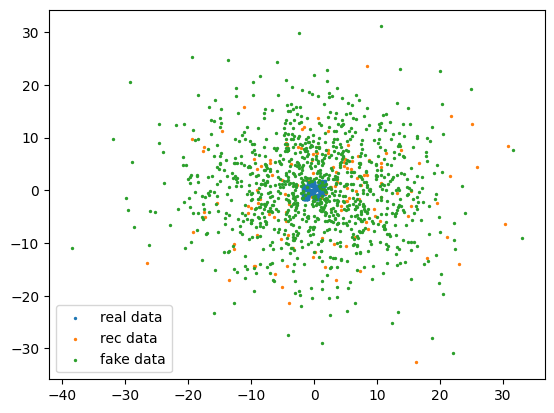

step 11000: KL: 9.842e-03, rec: 9.386e+02


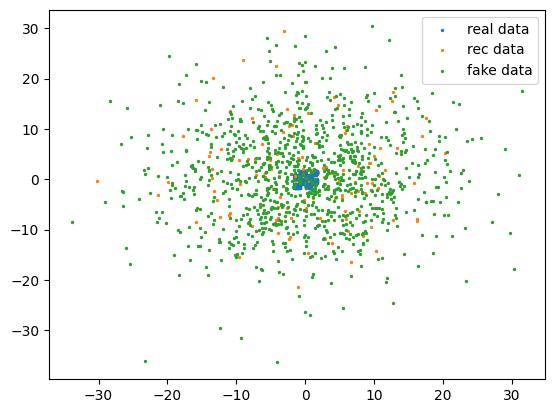

step 12000: KL: 5.650e-03, rec: 9.383e+02


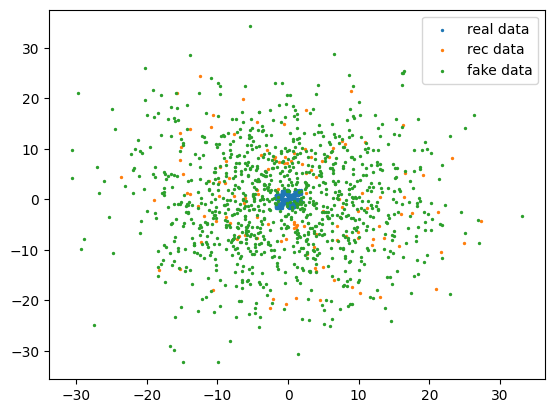

step 13000: KL: 1.202e-02, rec: 9.595e+02


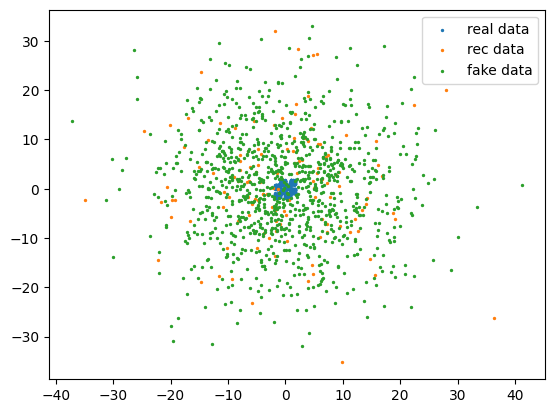

step 14000: KL: 6.575e-03, rec: 9.628e+02


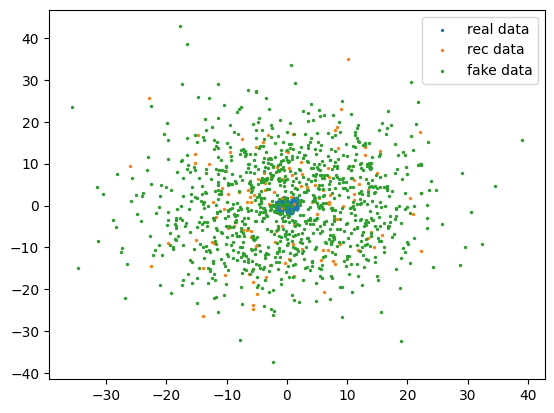

step 15000: KL: 4.815e-03, rec: 9.589e+02


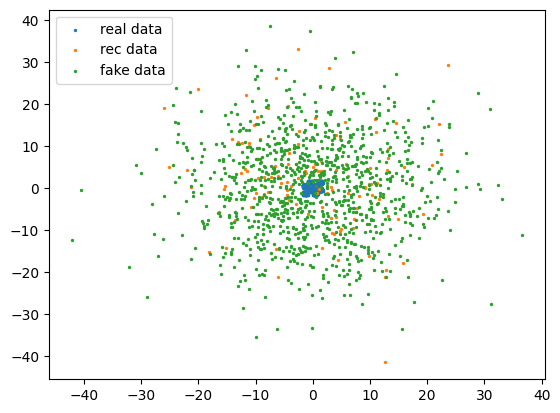

step 16000: KL: 1.134e-02, rec: 9.838e+02


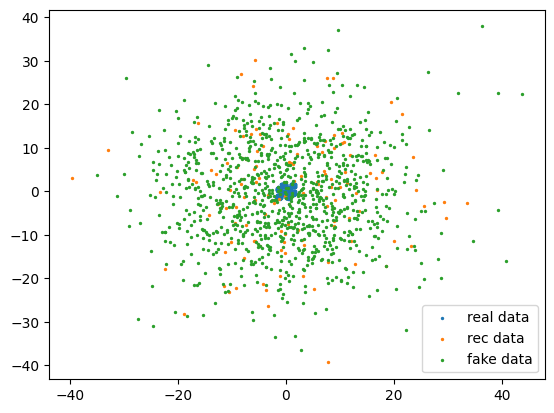

step 17000: KL: 5.541e-03, rec: 1.003e+03


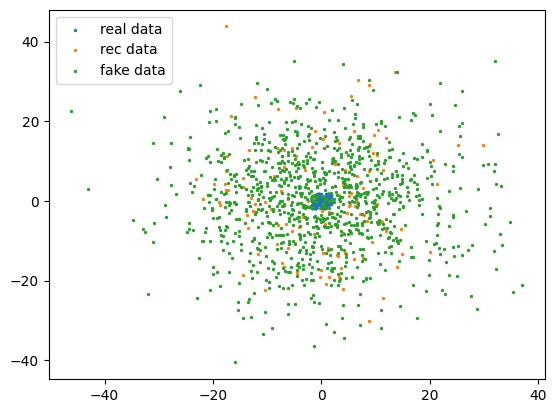

step 18000: KL: 6.969e-03, rec: 1.018e+03


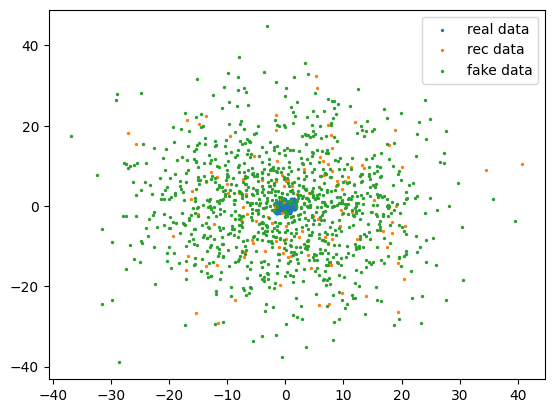

step 19000: KL: 6.208e-03, rec: 1.025e+03


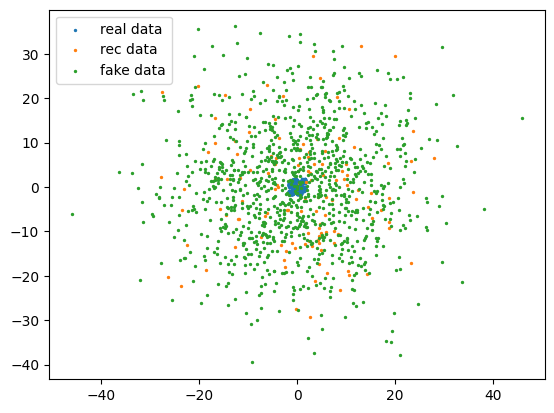

step 20000: KL: 2.661e-03, rec: 1.029e+03


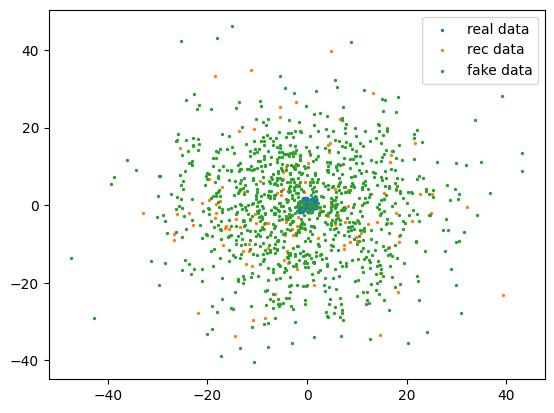

step 21000: KL: 9.614e-03, rec: 1.037e+03


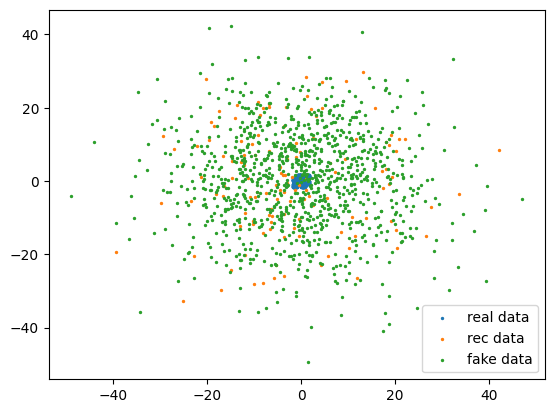

step 22000: KL: 5.724e-03, rec: 1.026e+03


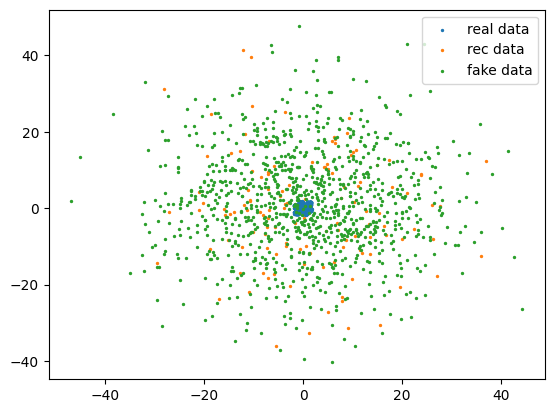

step 23000: KL: 4.808e-03, rec: 1.052e+03


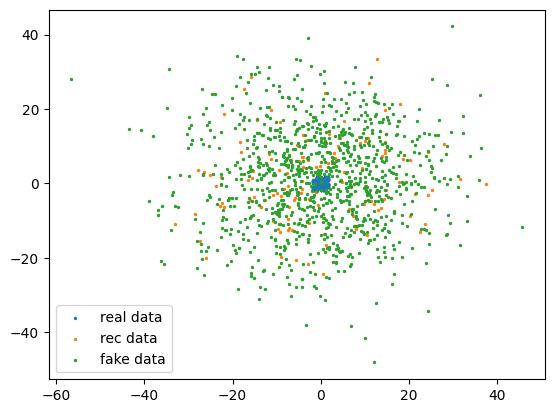

step 24000: KL: 6.236e-03, rec: 1.046e+03


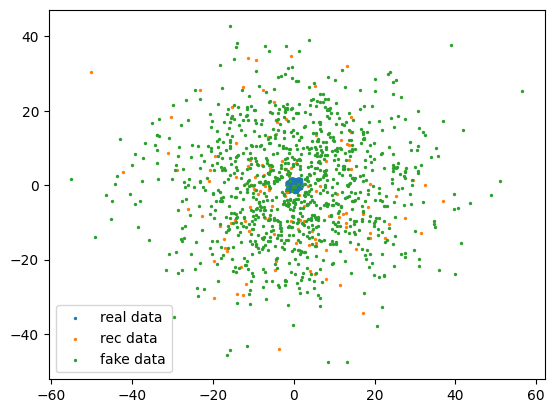

step 25000: KL: 9.396e-03, rec: 1.069e+03


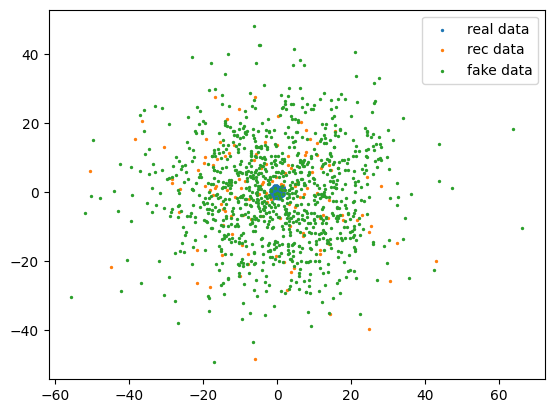

step 26000: KL: 7.606e-03, rec: 1.063e+03


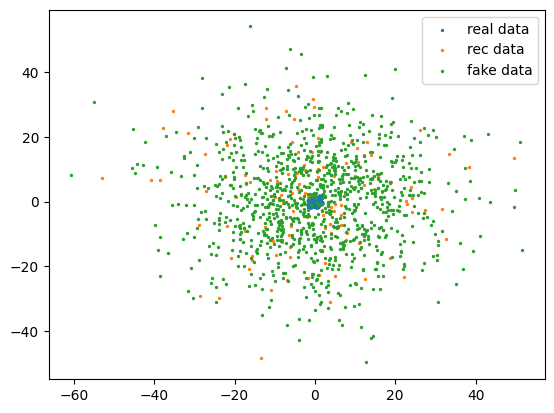

step 27000: KL: 7.713e-03, rec: 1.061e+03


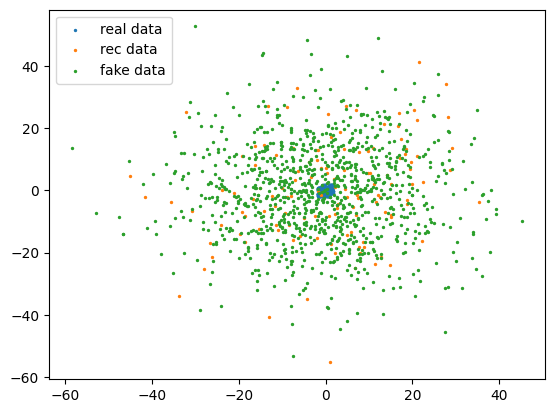

step 28000: KL: 6.139e-03, rec: 1.090e+03


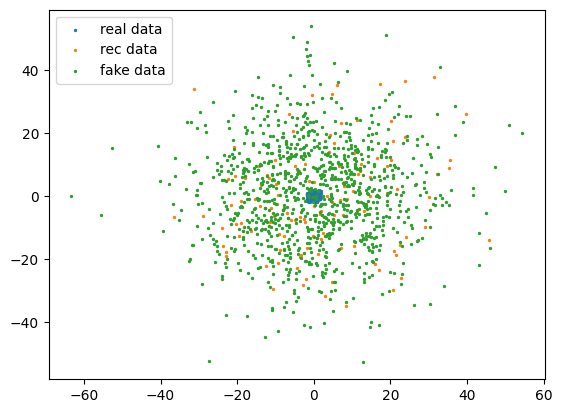

step 29000: KL: 1.257e-02, rec: 1.074e+03


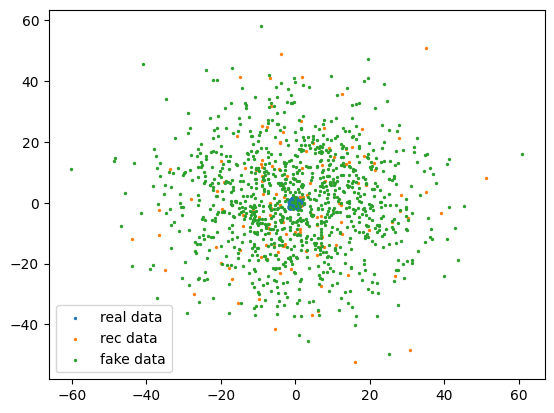

step 30000: KL: 9.164e-03, rec: 1.071e+03


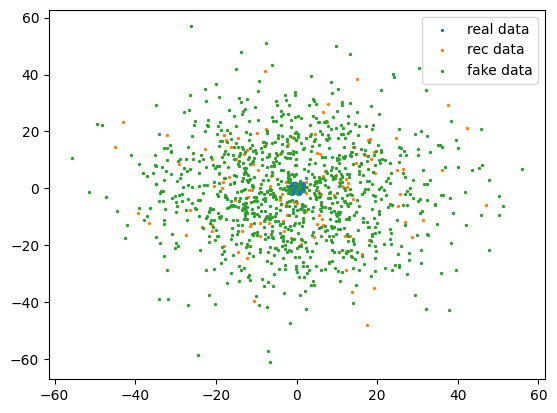

step 31000: KL: 8.236e-03, rec: 1.071e+03


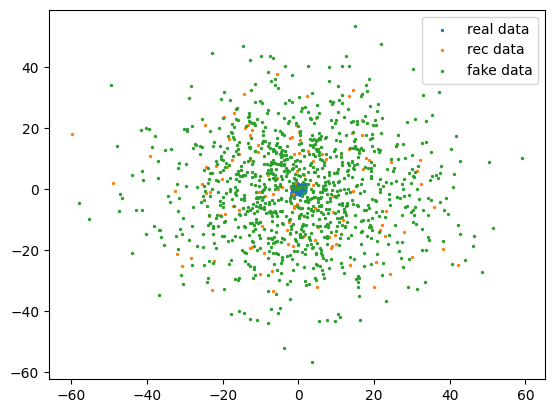

step 32000: KL: 8.347e-03, rec: 1.101e+03


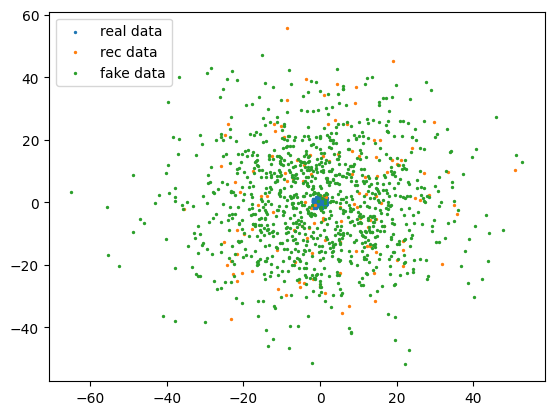

step 33000: KL: 9.160e-03, rec: 1.086e+03


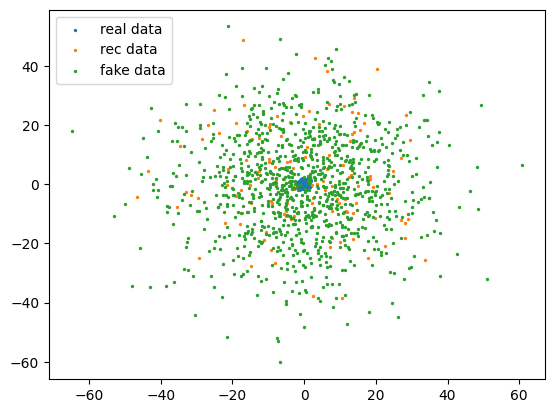

step 34000: KL: 1.154e-02, rec: 1.084e+03


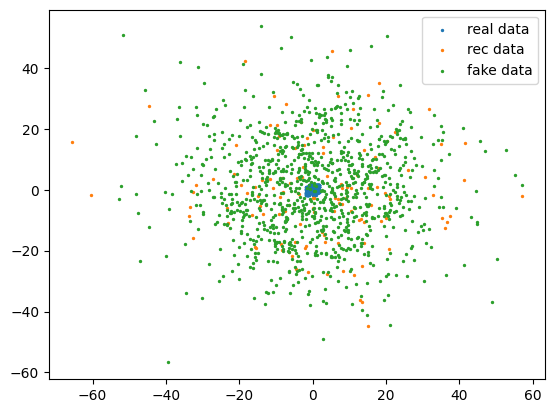

step 35000: KL: 5.564e-03, rec: 1.072e+03


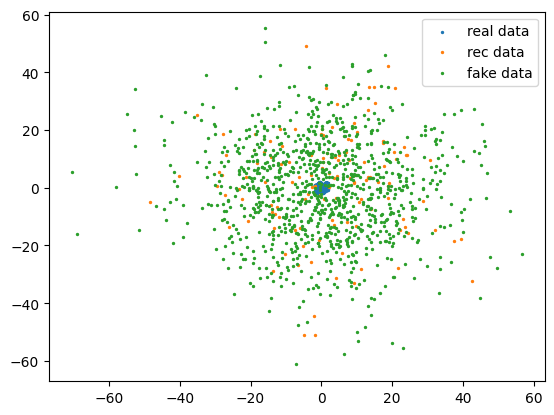

step 36000: KL: 1.627e-02, rec: 1.096e+03


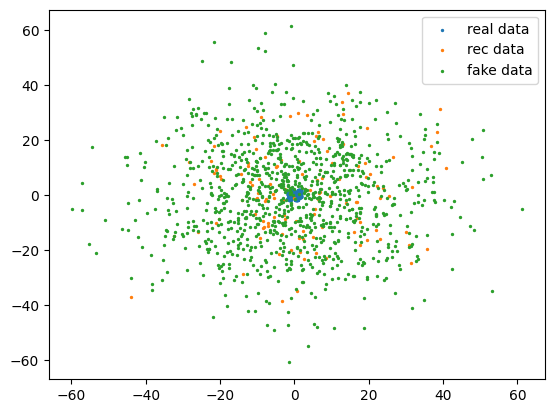

step 37000: KL: 8.853e-03, rec: 1.106e+03


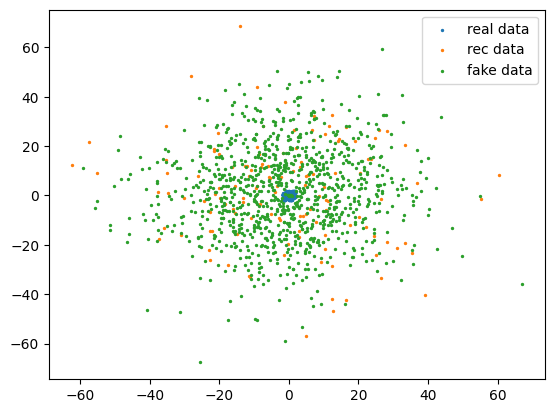

step 38000: KL: 9.725e-03, rec: 1.102e+03


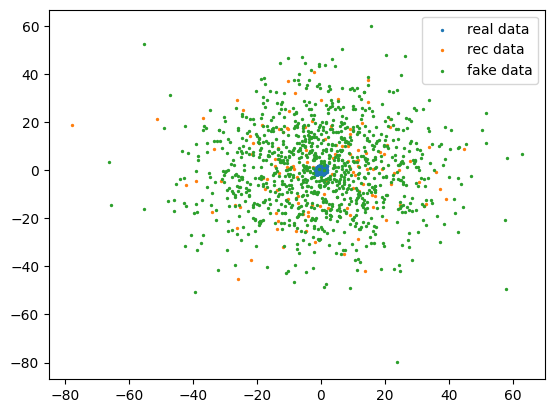

step 39000: KL: 8.836e-03, rec: 1.112e+03


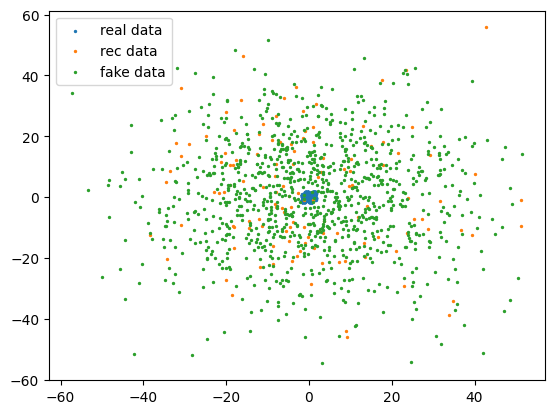

step 40000: KL: 9.673e-03, rec: 1.111e+03


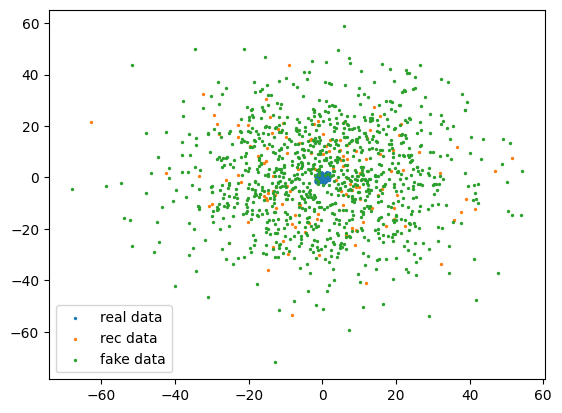

In [10]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()

    x = generate_batch(BATCHLEN)

    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    loss_kl = 0.5*torch.sum(enc_logvar.exp()+enc_mu.pow(2)-1-enc_logvar)
    #
    # SAMPLE z FROM q(z|x) HERE
    #
    std = torch.exp(0.5*enc_logvar)
    eps = torch.randn_like(std)
    z = enc_mu+eps*std

    dec_mu, dec_logvar = decoder(z)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    x_rec =torch.normal(dec_mu, torch.exp(0.5 * dec_logvar))

    rec_term = dec_logvar + ((x - x_rec) ** 2) / dec_logvar.exp()
    loss_rec = 0.5 * (x.shape[1] * torch.log(torch.tensor(2 * torch.pi)) + rec_term.sum(dim=1)).sum()

    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

<div class="alert alert-info">

It is seen a collapse episode during training, reconstructed data is not similar to real data reporting high reconstruction loss while $q_\phi(z|x)\approx p(z)$ with low KL divergence value. The model is excessively constrained by the regularization term over the latent space and it is not capable to learn the distribution of the marginal $p_\theta(x)$.

</div>

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

In [11]:
# Define the discriminator
class DecoderFixedVariance(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(LATENT_N, 2)

    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        mu = self.fc_mu(z)
        logvar = torch.log(torch.tensor(1e-4).expand_as(mu))
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

step 0: KL: 5.514e+02, rec: 1.956e+10


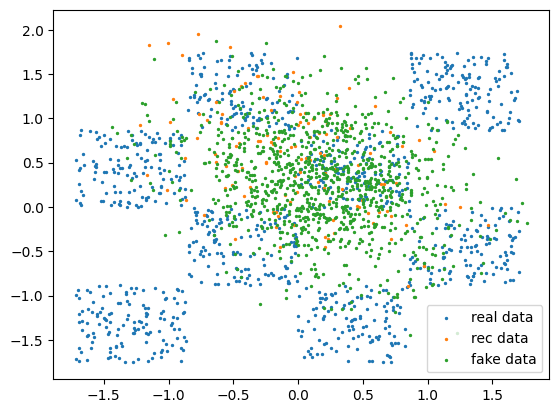

step 1000: KL: 2.176e+03, rec: 2.503e+08


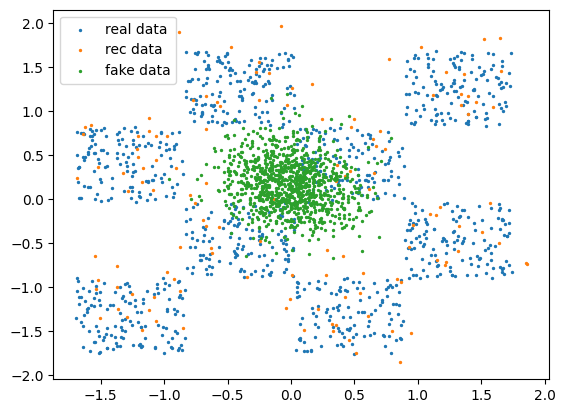

step 2000: KL: 4.463e+03, rec: 5.595e+07


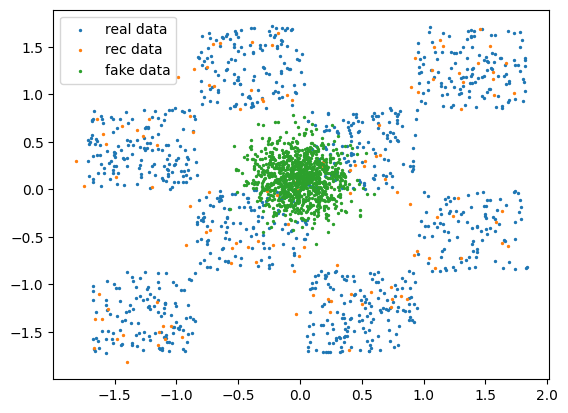

step 3000: KL: 6.080e+03, rec: 1.724e+07


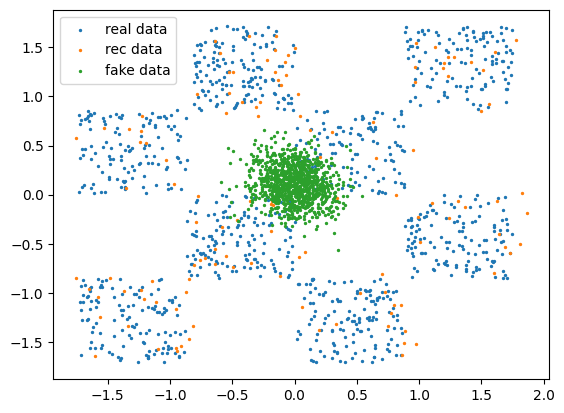

step 4000: KL: 7.117e+03, rec: 6.139e+06


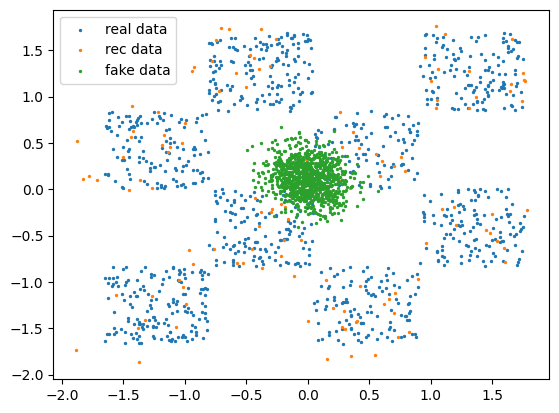

step 5000: KL: 8.003e+03, rec: 2.307e+06


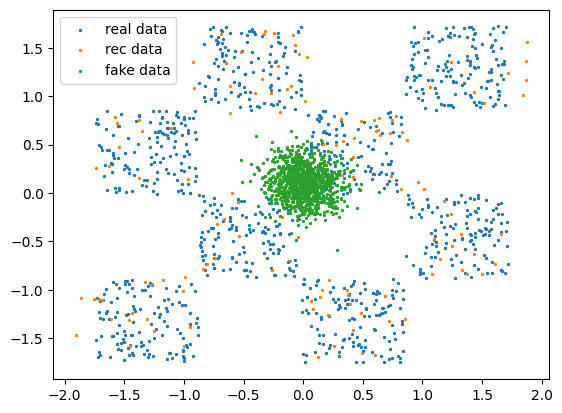

step 6000: KL: 8.776e+03, rec: 1.133e+06


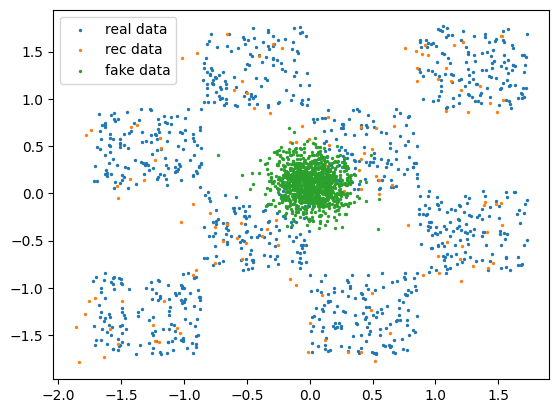

step 7000: KL: 9.366e+03, rec: 3.602e+05


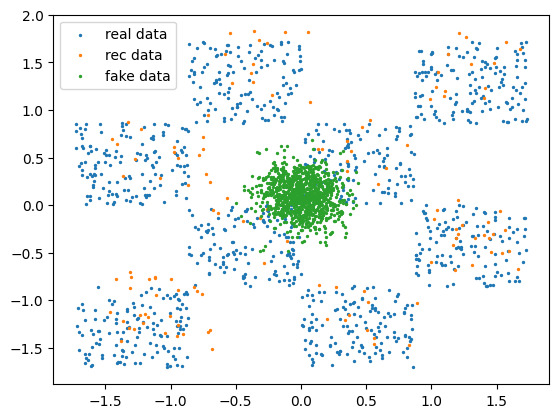

step 8000: KL: 9.936e+03, rec: 2.749e+05


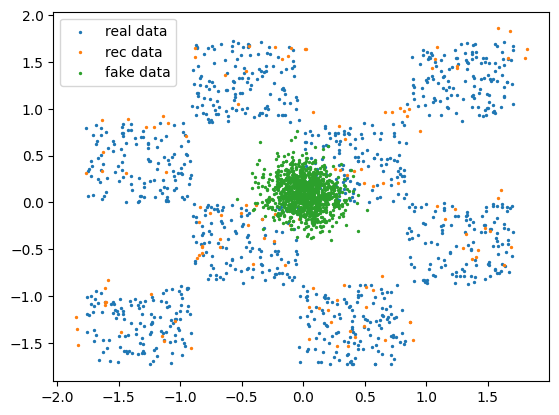

step 9000: KL: 1.051e+04, rec: 7.710e+04


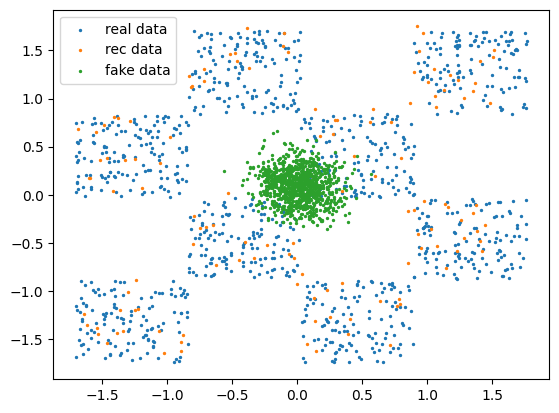

step 10000: KL: 1.109e+04, rec: 2.429e+05


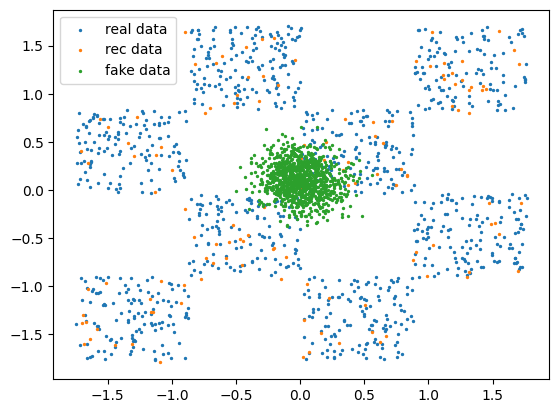

step 11000: KL: 1.148e+04, rec: 2.976e+05


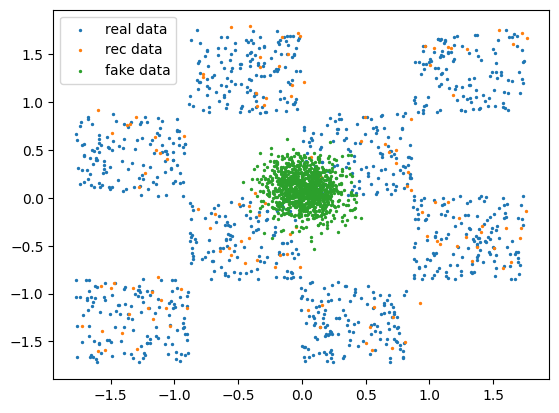

step 12000: KL: 1.184e+04, rec: 8.422e+04


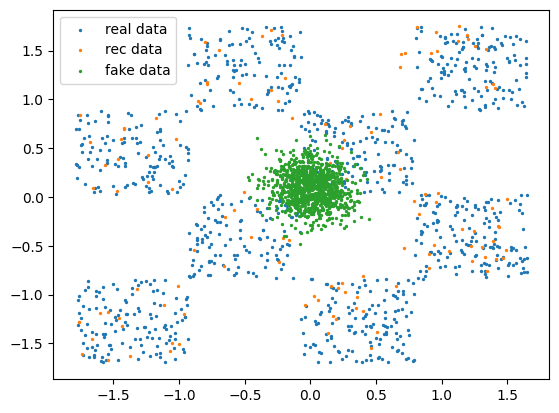

step 13000: KL: 1.214e+04, rec: 2.830e+05


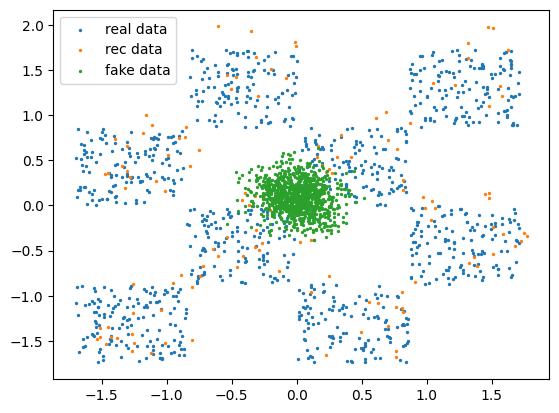

step 14000: KL: 1.235e+04, rec: 1.742e+04


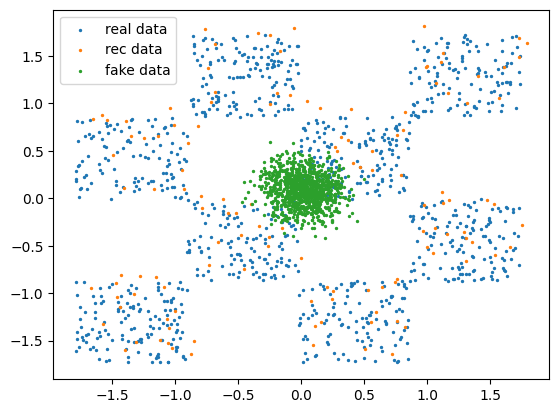

step 15000: KL: 1.252e+04, rec: 1.923e+05


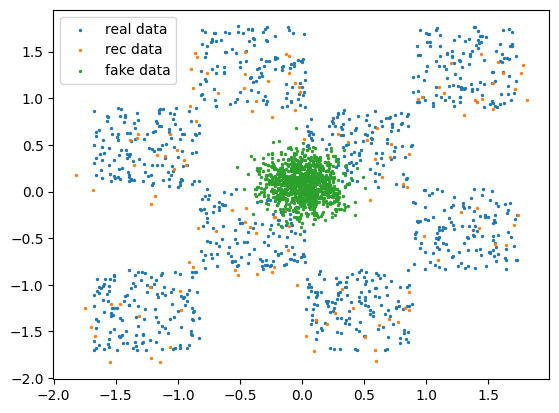

step 16000: KL: 1.257e+04, rec: 3.749e+04


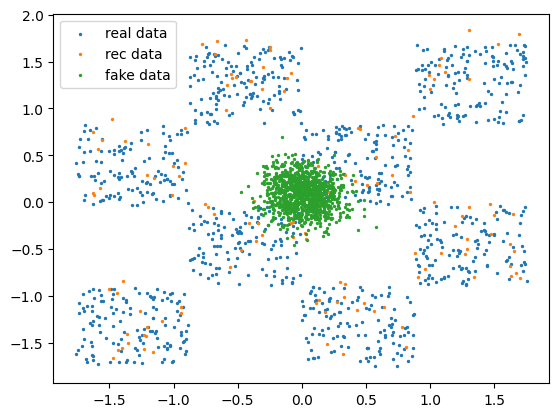

step 17000: KL: 1.270e+04, rec: 7.178e+03


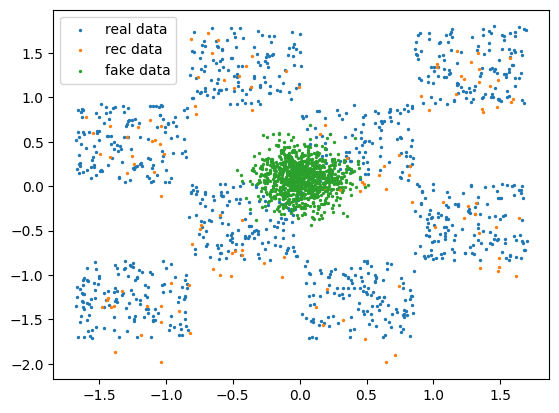

step 18000: KL: 1.272e+04, rec: 1.683e+05


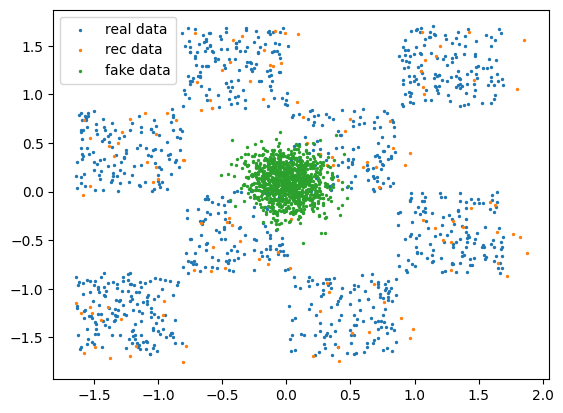

step 19000: KL: 1.279e+04, rec: 1.029e+05


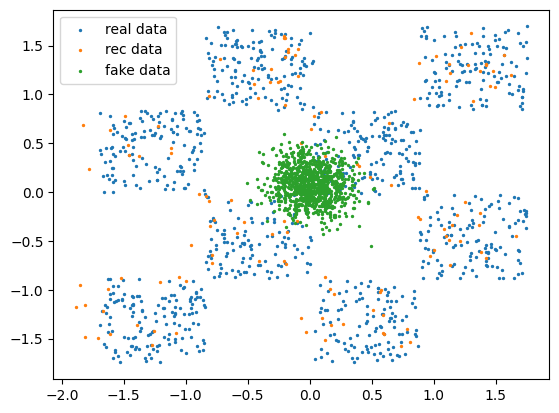

step 20000: KL: 1.281e+04, rec: 2.004e+05


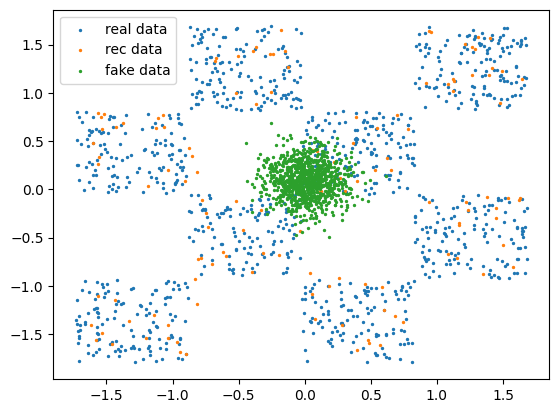

step 21000: KL: 1.281e+04, rec: 1.211e+05


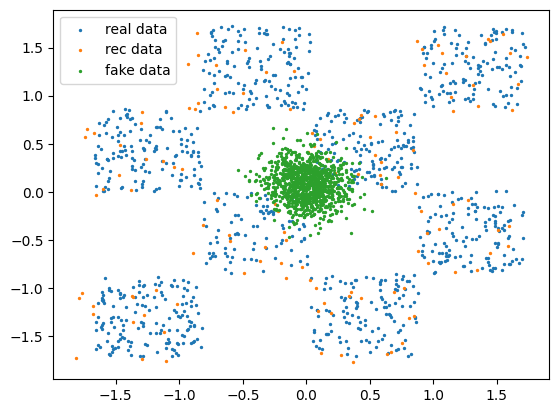

step 22000: KL: 1.281e+04, rec: 1.702e+05


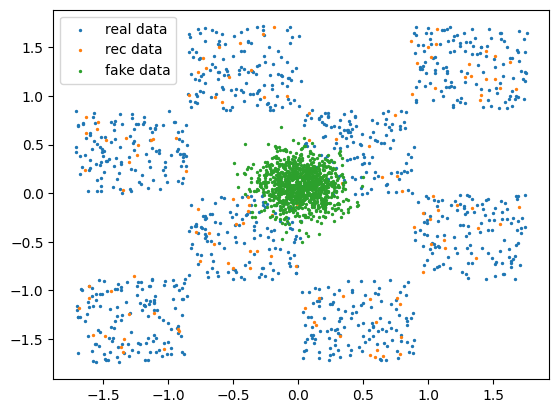

step 23000: KL: 1.282e+04, rec: 3.319e+05


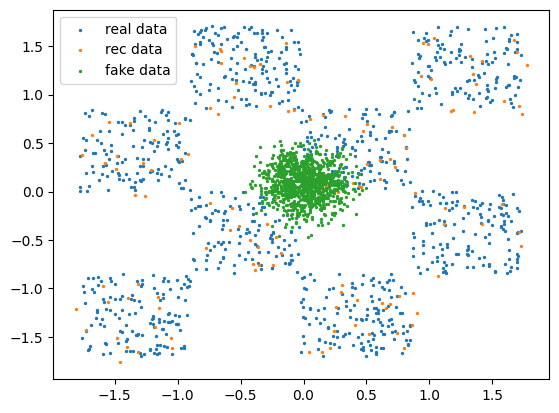

step 24000: KL: 1.283e+04, rec: 1.131e+05


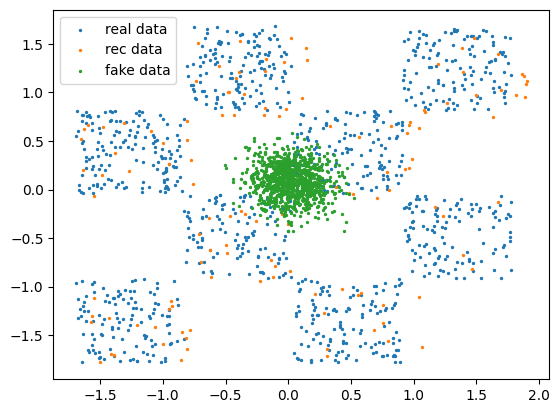

step 25000: KL: 1.273e+04, rec: 1.568e+04


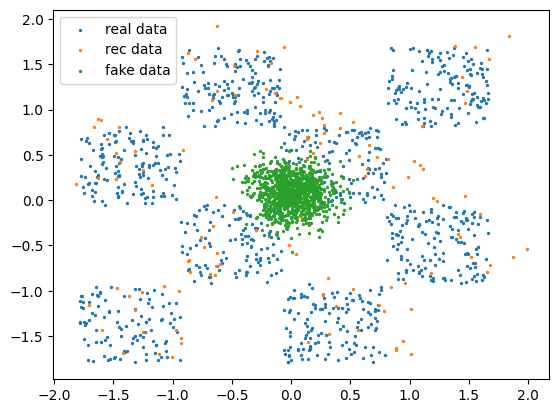

step 26000: KL: 1.278e+04, rec: 5.389e+03


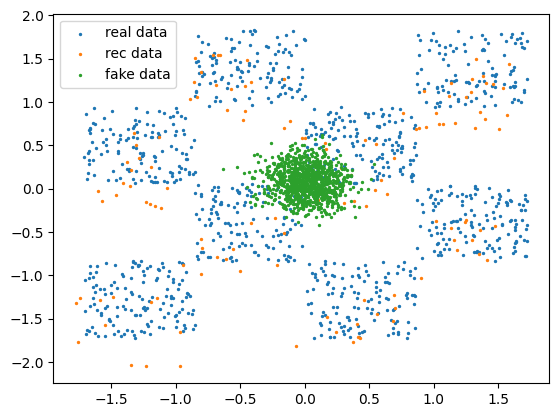

step 27000: KL: 1.273e+04, rec: 2.805e+05


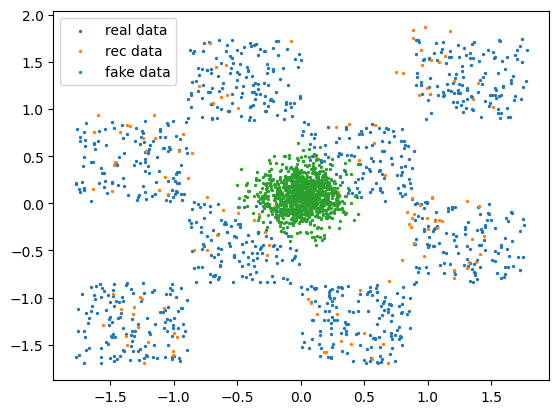

step 28000: KL: 1.271e+04, rec: 3.020e+04


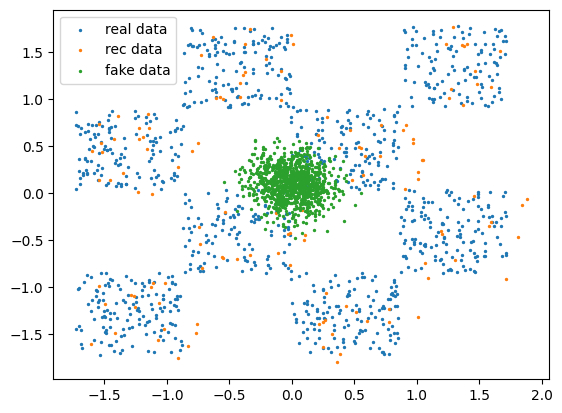

step 29000: KL: 1.273e+04, rec: 5.386e+04


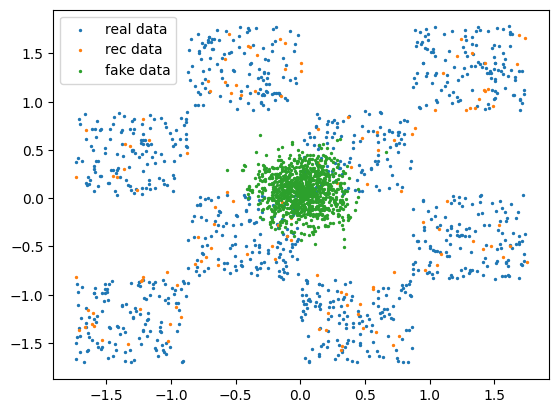

step 30000: KL: 1.260e+04, rec: 1.136e+05


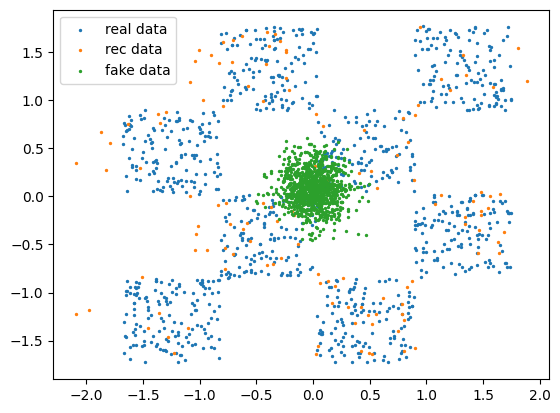

step 31000: KL: 1.263e+04, rec: 1.797e+03


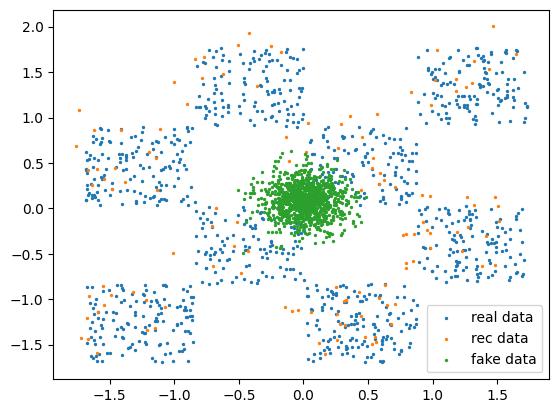

step 32000: KL: 1.267e+04, rec: 1.008e+05


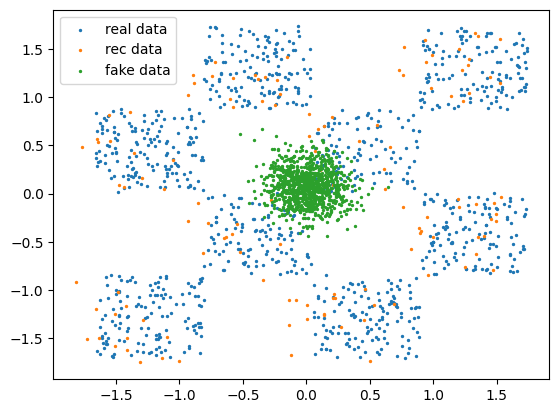

step 33000: KL: 1.267e+04, rec: 2.093e+05


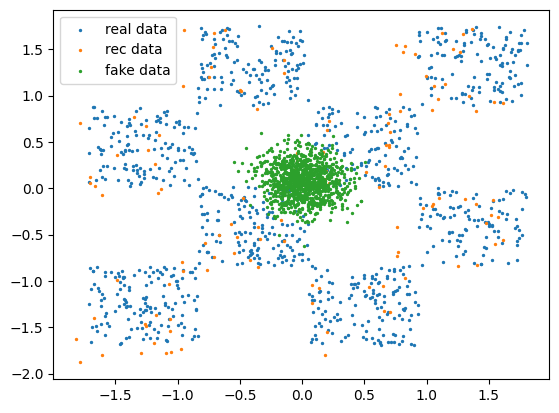

step 34000: KL: 1.261e+04, rec: 4.478e+04


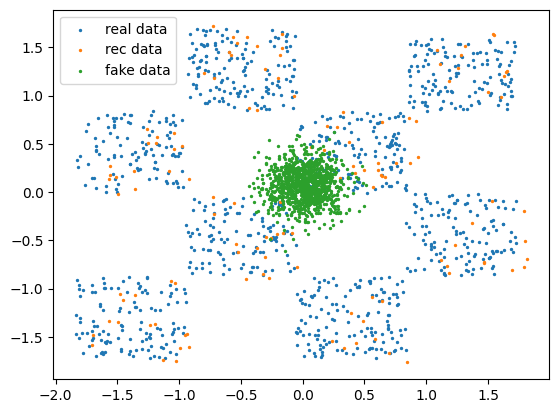

step 35000: KL: 1.258e+04, rec: 1.045e+04


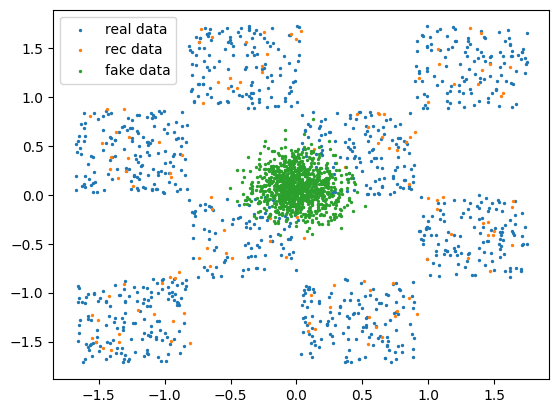

step 36000: KL: 1.252e+04, rec: 4.829e+04


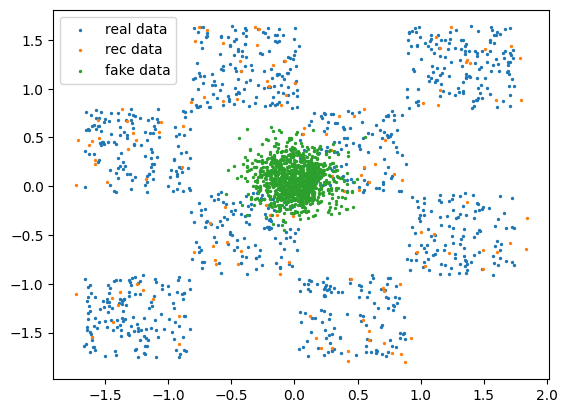

step 37000: KL: 1.253e+04, rec: 9.093e+04


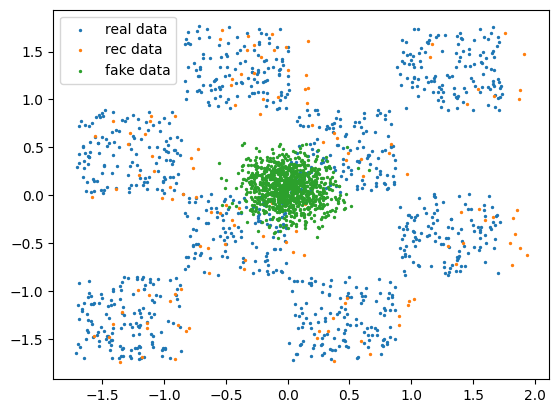

step 38000: KL: 1.250e+04, rec: 2.931e+05


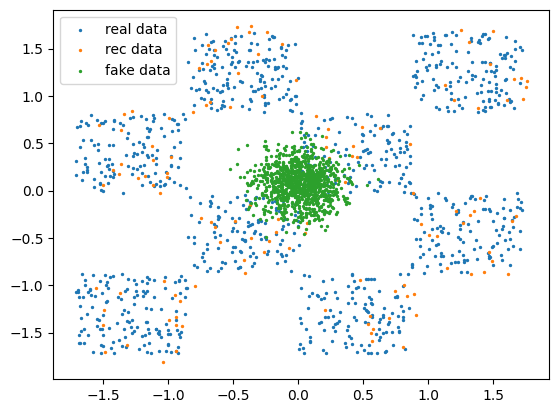

step 39000: KL: 1.253e+04, rec: 1.751e+05


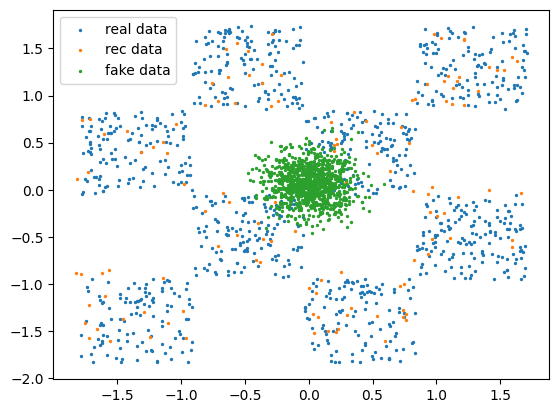

step 40000: KL: 1.251e+04, rec: 4.871e+04


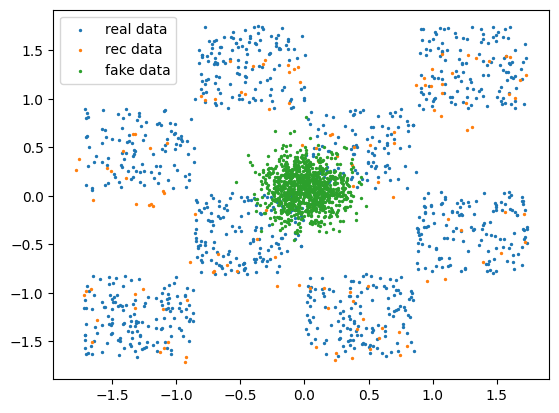

In [12]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = DecoderFixedVariance()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()

    x = generate_batch(BATCHLEN)

    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    loss_kl = 0.5 * torch.sum( enc_logvar.exp() + enc_mu.pow(2) - 1 - enc_logvar)

    #
    # SAMPLE z FROM q(z|x) HERE
    #
    std = torch.exp(0.5 * enc_logvar)
    eps = torch.randn_like(std)
    z = enc_mu + eps * std

    dec_mu, _ = decoder(z)
    hardcoded_sigma = torch.tensor(1e-4)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    d = LATENT_N
    loss_rec = (d * torch.log(torch.tensor(2 * torch.pi)) + d * torch.log(hardcoded_sigma**2) + ((x - dec_mu) ** 2).sum(dim=1) / hardcoded_sigma**2).sum() * 0.5

    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, hardcoded_sigma).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

<div class="alert alert-info">

**Results analysis:**

We can notice that, after fixing the log variance to very small values, the reconstruction capacity of the VAE increases significantly. This makes sense if we consider the fact that it is getting closer to the original idea of an AE: just reconstructing the original input from the learned representation reducing the uncertainty in the generation process. Even when it can be in overall benefitial, there can be some tasks potentially affected by this reduction in generation diversity.

</div>

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**

In [13]:
LATENT_N = 10  # latent space dimensionality

class Encoder(nn.Module):
    def __init__(self, input_dim=2, depth=2, width=128, latent_dim=LATENT_N):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for _ in range(depth):
            layers.append(nn.Linear(prev_dim, width))
            layers.append(nn.ReLU())
            prev_dim = width
        self.backbone = nn.Sequential(*layers)
        self.fc_mu = nn.Linear(prev_dim, latent_dim)
        self.fc_logvar = nn.Linear(prev_dim, latent_dim)

    def forward(self, x):
        h = self.backbone(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar


class DecoderFixedVariance(nn.Module):
    def __init__(self, output_dim=2, depth=2, width=128, latent_dim=LATENT_N):
        super().__init__()
        layers = []
        prev_dim = latent_dim
        for _ in range(depth):
            layers.append(nn.Linear(prev_dim, width))
            layers.append(nn.ReLU())
            prev_dim = width
        self.backbone = nn.Sequential(*layers)
        self.fc_mu = nn.Linear(prev_dim, output_dim)

    def forward(self, z):
        h = self.backbone(z)
        mu = self.fc_mu(h)
        logvar = torch.log(torch.tensor(1e-4).expand_as(mu))  # fixed variance
        return mu, logvar

    def generate(self, batchlen):
        z = torch.randn(batchlen, LATENT_N)
        mu, logvar = self.forward(z)
        return torch.normal(mu, torch.exp(0.5 * logvar))

In [14]:
LATENT_N = 10
N_ITER = 40001
BATCHLEN = 128

def train_and_plot(depth_enc, width_enc, depth_dec, width_dec):
    print(f"\nTraining VAE with depth_enc={depth_enc}, width_enc={width_enc}, depth_dec={depth_dec}, width_enc={width_dec}")
    encoder = Encoder(depth=depth_enc, width=width_enc)
    decoder = DecoderFixedVariance(depth=depth_dec, width=width_dec)
    optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5, 0.9))
    optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5, 0.9))

    for i in range(N_ITER):
        encoder.zero_grad()
        decoder.zero_grad()

        x = generate_batch(BATCHLEN)
        enc_mu, enc_logvar = encoder(x)

        # KL divergence
        loss_kl = 0.5 * torch.sum(enc_logvar.exp() + enc_mu.pow(2) - 1 - enc_logvar)

        # Sample z ~ q(z|x)
        std = torch.exp(0.5 * enc_logvar)
        eps = torch.randn_like(std)
        z = enc_mu + eps * std

        dec_mu, _ = decoder(z)
        hardcoded_sigma = torch.tensor(1e-4)
        d = LATENT_N
        loss_rec = (d * torch.log(torch.tensor(2 * torch.pi)) + d * torch.log(hardcoded_sigma**2) + ((x - dec_mu) ** 2).sum(dim=1) / hardcoded_sigma**2).sum() * 0.5


        (loss_kl + loss_rec).backward()
        optim_enc.step()
        optim_dec.step()

        if i % 1000 == 0:
            print(f"step {i}: KL: {float(loss_kl):.3e}, rec: {float(loss_rec):.3e}")

    # Final plot for this configuration
    real_batch = generate_batch(1024)
    rec_batch = torch.normal(dec_mu, hardcoded_sigma).detach()
    fake_batch = decoder.generate(1024).detach()
    plt.figure(figsize=(6, 6))
    plt.title(f"depth_enc={depth_enc}, width_enc={width_enc}, depth_dec={depth_dec}, width_dec={width_dec}")
    plt.scatter(real_batch[:, 0], real_batch[:, 1], s=2.0, label='real')
    plt.scatter(rec_batch[:, 0], rec_batch[:, 1], s=2.0, label='recon')
    plt.scatter(fake_batch[:, 0], fake_batch[:, 1], s=2.0, label='fake')
    plt.legend()
    plt.show()


Training VAE with depth_enc=2, width_enc=64, depth_dec=1, width_enc=64
step 0: KL: 3.704e+01, rec: 1.352e+10
step 1000: KL: 1.045e+04, rec: 1.929e+06
step 2000: KL: 1.094e+04, rec: 3.151e+05
step 3000: KL: 1.087e+04, rec: 1.710e+06
step 4000: KL: 1.090e+04, rec: 1.334e+06
step 5000: KL: 1.094e+04, rec: 1.234e+06
step 6000: KL: 1.095e+04, rec: 3.650e+06
step 7000: KL: 1.100e+04, rec: 1.884e+06
step 8000: KL: 1.094e+04, rec: 1.017e+06
step 9000: KL: 1.100e+04, rec: 2.801e+05
step 10000: KL: 1.100e+04, rec: 1.240e+06
step 11000: KL: 1.089e+04, rec: 3.400e+06
step 12000: KL: 1.096e+04, rec: 8.265e+05
step 13000: KL: 1.101e+04, rec: 1.141e+07
step 14000: KL: 1.093e+04, rec: 2.659e+06
step 15000: KL: 1.095e+04, rec: 2.791e+06
step 16000: KL: 1.087e+04, rec: 1.480e+06
step 17000: KL: 1.079e+04, rec: 2.576e+06
step 18000: KL: 1.055e+04, rec: 8.180e+05
step 19000: KL: 1.054e+04, rec: 3.018e+05
step 20000: KL: 1.046e+04, rec: 1.622e+06
step 21000: KL: 1.040e+04, rec: 2.896e+06
step 22000: KL: 1

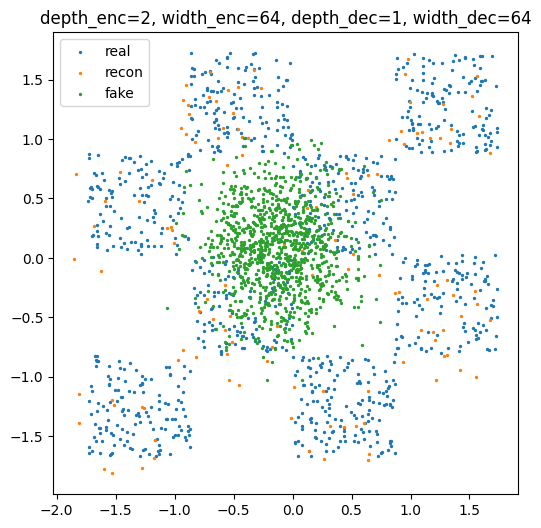


Training VAE with depth_enc=2, width_enc=64, depth_dec=1, width_enc=128
step 0: KL: 1.224e+01, rec: 1.384e+10
step 1000: KL: 9.914e+03, rec: 5.439e+06
step 2000: KL: 1.039e+04, rec: 5.658e+05
step 3000: KL: 1.060e+04, rec: 1.044e+07
step 4000: KL: 1.055e+04, rec: 7.011e+06
step 5000: KL: 1.071e+04, rec: 2.986e+05
step 6000: KL: 1.057e+04, rec: 1.380e+06
step 7000: KL: 1.069e+04, rec: 2.350e+06
step 8000: KL: 1.086e+04, rec: 9.518e+05
step 9000: KL: 1.097e+04, rec: 2.092e+06
step 10000: KL: 1.094e+04, rec: 8.804e+05
step 11000: KL: 1.085e+04, rec: 1.071e+06
step 12000: KL: 1.098e+04, rec: 4.403e+06
step 13000: KL: 1.080e+04, rec: 2.143e+06
step 14000: KL: 1.085e+04, rec: 3.518e+05
step 15000: KL: 1.086e+04, rec: 6.340e+06
step 16000: KL: 1.085e+04, rec: 1.187e+06
step 17000: KL: 1.072e+04, rec: 5.576e+05
step 18000: KL: 1.065e+04, rec: 5.489e+05
step 19000: KL: 1.047e+04, rec: 8.201e+05
step 20000: KL: 1.041e+04, rec: 8.459e+05
step 21000: KL: 1.036e+04, rec: 4.717e+05
step 22000: KL: 

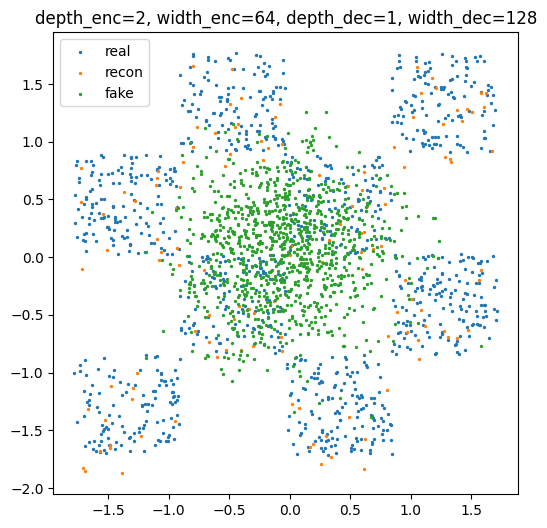


Training VAE with depth_enc=2, width_enc=64, depth_dec=2, width_enc=64
step 0: KL: 1.854e+01, rec: 1.299e+10
step 1000: KL: 1.097e+04, rec: 1.111e+07
step 2000: KL: 1.141e+04, rec: 9.785e+06
step 3000: KL: 1.137e+04, rec: 1.346e+06
step 4000: KL: 1.155e+04, rec: 3.672e+06
step 5000: KL: 1.169e+04, rec: 1.502e+06
step 6000: KL: 1.185e+04, rec: 1.413e+07
step 7000: KL: 1.180e+04, rec: 6.047e+06
step 8000: KL: 1.204e+04, rec: 1.954e+06
step 9000: KL: 1.186e+04, rec: 1.016e+06
step 10000: KL: 1.200e+04, rec: 2.339e+06
step 11000: KL: 1.205e+04, rec: 4.991e+05
step 12000: KL: 1.188e+04, rec: 2.786e+06
step 13000: KL: 1.168e+04, rec: 3.119e+06
step 14000: KL: 1.162e+04, rec: 3.214e+06
step 15000: KL: 1.169e+04, rec: 1.101e+06
step 16000: KL: 1.139e+04, rec: 1.535e+06
step 17000: KL: 1.135e+04, rec: 3.941e+06
step 18000: KL: 1.103e+04, rec: 9.581e+05
step 19000: KL: 1.092e+04, rec: 4.925e+06
step 20000: KL: 1.089e+04, rec: 6.765e+05
step 21000: KL: 1.072e+04, rec: 1.654e+06
step 22000: KL: 1

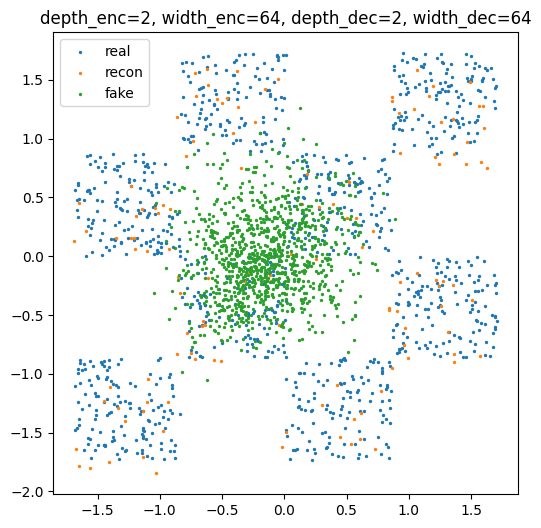


Training VAE with depth_enc=2, width_enc=64, depth_dec=2, width_enc=128
step 0: KL: 1.570e+01, rec: 1.288e+10
step 1000: KL: 1.016e+04, rec: 1.169e+07
step 2000: KL: 1.096e+04, rec: 5.581e+06
step 3000: KL: 1.134e+04, rec: 7.093e+06
step 4000: KL: 1.125e+04, rec: 5.149e+06
step 5000: KL: 1.128e+04, rec: 5.094e+05
step 6000: KL: 1.156e+04, rec: 7.395e+06
step 7000: KL: 1.169e+04, rec: 9.005e+06
step 8000: KL: 1.176e+04, rec: 2.075e+05
step 9000: KL: 1.192e+04, rec: 4.045e+06
step 10000: KL: 1.194e+04, rec: 2.541e+05
step 11000: KL: 1.202e+04, rec: 2.166e+06
step 12000: KL: 1.191e+04, rec: 1.570e+06
step 13000: KL: 1.200e+04, rec: 3.310e+06
step 14000: KL: 1.182e+04, rec: 9.849e+06
step 15000: KL: 1.180e+04, rec: 4.385e+06
step 16000: KL: 1.154e+04, rec: 4.564e+06
step 17000: KL: 1.169e+04, rec: 2.647e+06
step 18000: KL: 1.116e+04, rec: 6.407e+06
step 19000: KL: 1.109e+04, rec: 3.128e+06
step 20000: KL: 1.093e+04, rec: 6.813e+05
step 21000: KL: 1.092e+04, rec: 1.517e+06
step 22000: KL: 

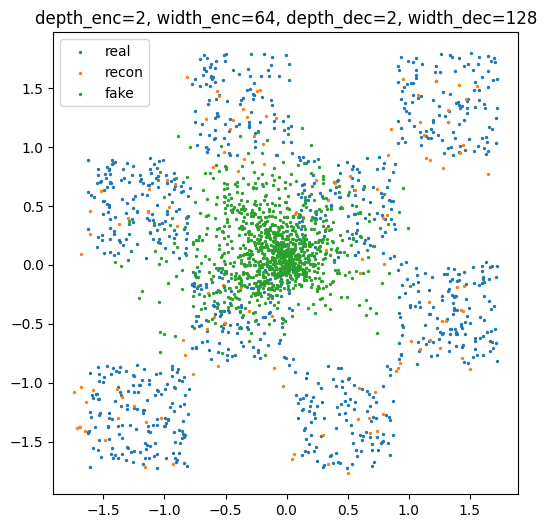

In [15]:
import itertools

depth_values = [1, 2]
width_values = [64, 128]

for depth, width in itertools.product(depth_values, width_values):
    train_and_plot(2, 64, depth, width)


Training VAE with depth_enc=1, width_enc=64, depth_dec=2, width_enc=64
step 0: KL: 6.543e+01, rec: 1.336e+10
step 1000: KL: 9.812e+03, rec: 6.439e+05
step 2000: KL: 1.115e+04, rec: 8.996e+05
step 3000: KL: 1.125e+04, rec: 4.329e+05
step 4000: KL: 1.084e+04, rec: 1.343e+06
step 5000: KL: 1.067e+04, rec: 2.835e+06
step 6000: KL: 1.061e+04, rec: 8.938e+06
step 7000: KL: 1.043e+04, rec: 7.196e+05
step 8000: KL: 1.024e+04, rec: 1.337e+06
step 9000: KL: 1.013e+04, rec: 2.651e+05
step 10000: KL: 1.023e+04, rec: 2.866e+06
step 11000: KL: 1.012e+04, rec: 1.030e+06
step 12000: KL: 1.015e+04, rec: 8.161e+05
step 13000: KL: 1.005e+04, rec: 3.212e+05
step 14000: KL: 9.953e+03, rec: 7.220e+05
step 15000: KL: 9.918e+03, rec: 4.782e+05
step 16000: KL: 9.776e+03, rec: 3.511e+06
step 17000: KL: 9.870e+03, rec: 3.550e+05
step 18000: KL: 9.874e+03, rec: 9.587e+05
step 19000: KL: 9.837e+03, rec: 2.126e+06
step 20000: KL: 9.841e+03, rec: 1.884e+06
step 21000: KL: 9.750e+03, rec: 3.198e+06
step 22000: KL: 9

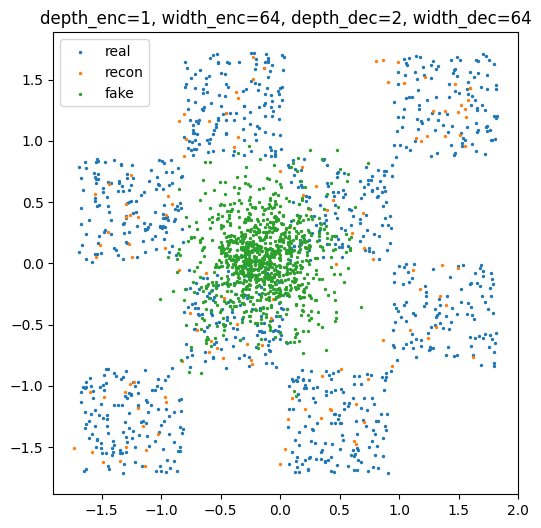


Training VAE with depth_enc=1, width_enc=128, depth_dec=2, width_enc=64
step 0: KL: 8.415e+01, rec: 1.312e+10
step 1000: KL: 1.109e+04, rec: 1.118e+06
step 2000: KL: 1.119e+04, rec: 5.492e+06
step 3000: KL: 1.084e+04, rec: 1.867e+06
step 4000: KL: 1.062e+04, rec: 2.568e+06
step 5000: KL: 1.032e+04, rec: 1.817e+06
step 6000: KL: 1.024e+04, rec: 1.099e+06
step 7000: KL: 1.027e+04, rec: 6.194e+05
step 8000: KL: 1.018e+04, rec: 1.257e+06
step 9000: KL: 9.917e+03, rec: 1.371e+06
step 10000: KL: 9.920e+03, rec: 2.339e+06
step 11000: KL: 1.007e+04, rec: 6.628e+06
step 12000: KL: 9.993e+03, rec: 1.707e+06
step 13000: KL: 9.916e+03, rec: 2.887e+06
step 14000: KL: 9.822e+03, rec: 2.117e+06
step 15000: KL: 9.699e+03, rec: 6.370e+05
step 16000: KL: 9.669e+03, rec: 3.126e+06
step 17000: KL: 9.629e+03, rec: 6.880e+05
step 18000: KL: 9.603e+03, rec: 1.461e+06
step 19000: KL: 9.808e+03, rec: 4.500e+06
step 20000: KL: 9.682e+03, rec: 3.319e+05
step 21000: KL: 9.587e+03, rec: 1.773e+06
step 22000: KL: 

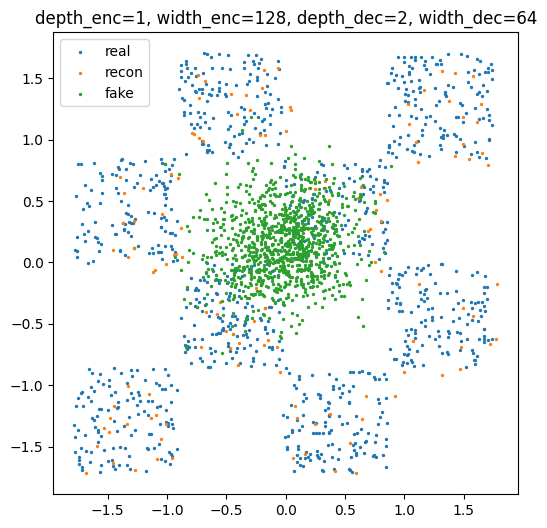


Training VAE with depth_enc=2, width_enc=64, depth_dec=2, width_enc=64
step 0: KL: 1.300e+01, rec: 1.278e+10
step 1000: KL: 1.081e+04, rec: 3.172e+06
step 2000: KL: 1.134e+04, rec: 2.327e+06
step 3000: KL: 1.116e+04, rec: 1.011e+07
step 4000: KL: 1.140e+04, rec: 4.830e+06
step 5000: KL: 1.153e+04, rec: 2.660e+06
step 6000: KL: 1.149e+04, rec: 3.242e+06
step 7000: KL: 1.158e+04, rec: 3.454e+05
step 8000: KL: 1.159e+04, rec: 7.047e+06
step 9000: KL: 1.161e+04, rec: 6.800e+06
step 10000: KL: 1.175e+04, rec: 2.647e+06
step 11000: KL: 1.174e+04, rec: 1.690e+06
step 12000: KL: 1.161e+04, rec: 2.524e+06
step 13000: KL: 1.161e+04, rec: 2.606e+06
step 14000: KL: 1.163e+04, rec: 6.337e+05
step 15000: KL: 1.153e+04, rec: 5.465e+06
step 16000: KL: 1.168e+04, rec: 1.405e+06
step 17000: KL: 1.159e+04, rec: 6.391e+05
step 18000: KL: 1.152e+04, rec: 8.436e+06
step 19000: KL: 1.147e+04, rec: 2.929e+06
step 20000: KL: 1.115e+04, rec: 3.395e+05
step 21000: KL: 1.136e+04, rec: 4.411e+05
step 22000: KL: 1

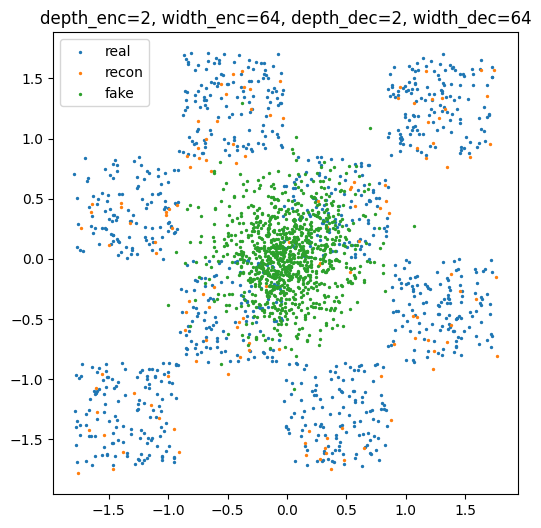


Training VAE with depth_enc=2, width_enc=128, depth_dec=2, width_enc=64
step 0: KL: 1.530e+01, rec: 1.355e+10
step 1000: KL: 1.201e+04, rec: 5.791e+06
step 2000: KL: 1.259e+04, rec: 4.046e+06
step 3000: KL: 1.306e+04, rec: 6.537e+06
step 4000: KL: 1.342e+04, rec: 3.272e+06
step 5000: KL: 1.325e+04, rec: 3.739e+06
step 6000: KL: 1.315e+04, rec: 8.215e+06
step 7000: KL: 1.291e+04, rec: 1.173e+07
step 8000: KL: 1.243e+04, rec: 5.949e+06
step 9000: KL: 1.194e+04, rec: 2.561e+05
step 10000: KL: 1.162e+04, rec: 1.325e+06
step 11000: KL: 1.127e+04, rec: 3.002e+06
step 12000: KL: 1.127e+04, rec: 3.041e+06
step 13000: KL: 1.094e+04, rec: 5.659e+06
step 14000: KL: 1.086e+04, rec: 3.604e+06
step 15000: KL: 1.055e+04, rec: 7.638e+06
step 16000: KL: 1.045e+04, rec: 1.658e+06
step 17000: KL: 1.045e+04, rec: 6.368e+05
step 18000: KL: 1.030e+04, rec: 1.049e+05
step 19000: KL: 1.038e+04, rec: 1.000e+07
step 20000: KL: 1.018e+04, rec: 5.220e+06
step 21000: KL: 1.013e+04, rec: 9.788e+05
step 22000: KL: 

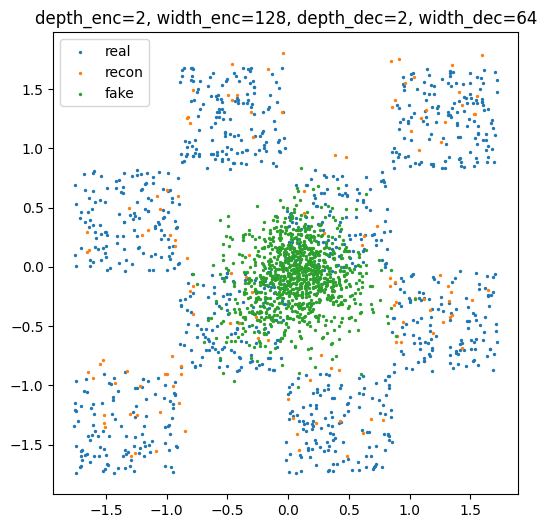

In [16]:
depth_values = [1, 2]
width_values = [64, 128]

for depth, width in itertools.product(depth_values, width_values):
    train_and_plot(depth, width, 2, 64)

<div class="alert alert-info">

**Answer:**

The results obtained does not show a big impact in changing the capacity of the Encoder and Decoder architectures, at least for the specific data we are dealing with. Moreover, different techniques to increase the latent space regularization could be more effective in this case, such as $\beta$-VAE.

</div>

---
## Conclusion

**Q.28: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs, Flow Matching and Denoising Models ?**

<div class="alert alert-info">

Overall, GANs produced the better results when it comes to generating data following a certain pattern.

On the one hand, GANs are able to produce highly realistic samples and can deal with complex data distributions, while offering a versatile architecture. On the other hand, GANs present the risk of mode collapse (as seen in Q5) during training, making it essential to make the correct hyperparameter selection (as done in Q8).

Meanwhile, VAEs offer more stable training and explicit likelihood estimation, but typically produce lower-quality generated data compared to GANs. They may provide better disentangled representations in latent space through regularization such as $\beta$-VAE.

</div>